In [1]:
import pandas as pd
import geopandas as gpd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.ticker as ticker
from matplotlib.cm import ScalarMappable
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

import pickle

from math import radians, cos, sin, sqrt, atan2

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import d2_absolute_error_score
from sklearn.metrics import mean_squared_error
# from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.cluster import KMeans
from sklearn.cluster import HDBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from matplotlib.colors import Normalize
from matplotlib.colors import ListedColormap

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import random

import libpysal as lp
from libpysal.weights import DistanceBand
from esda.moran import Moran

# from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.basemap import Basemap

# For sanity checking
from sklearn.decomposition import PCA

from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay

from scipy.stats import norm
from scipy.stats import kurtosis
from scipy.stats import gaussian_kde
from scipy.spatial.distance import cdist

import glob

from geopy.distance import geodesic

from joblib import dump, load
from tqdm.notebook import tqdm

import os
import shutil
import pysplit
import time

# These packages are used when the code to plot the decision tree is uncommented
# See **TREE PLOTTING** section and un-uncomment the code there
from sklearn.tree import plot_tree
from sklearn.tree import export_text

import warnings
from geopy.distance import geodesic

# import umap
from geopy.distance import great_circle
from joblib import Parallel, delayed
# from haversine import haversine, Unit
# from numba import jit

# plt.ioff()

In [2]:
# Define a function that calcualte error metrics from predicted and actual values
def reg_model_metrics(actual,pred):
    MSE = mean_squared_error(actual,pred)
    RMSE = np.sqrt(MSE)
    actual_mean = np.mean(actual)
    RRMSE = 100*RMSE/actual_mean
    MAE = mean_absolute_error(actual, pred)
    R2 = r2_score(actual,pred)
    D2 = d2_absolute_error_score(actual, pred)
    MAXErr = max_error(actual, pred)
    EVS = explained_variance_score(actual, pred)
    return MSE, RMSE, RRMSE, MAE, R2, D2, MAXErr, EVS 

# Function to calculate and organize metrics
def calculate_and_organize_metrics_cluster(actual, pred, cluster, label, train_test=""):
     
    # Calculate standard error metrics
    mse, rmse, rrmse, mae, r2, d2, max_err, evs = reg_model_metrics(actual, pred)
    
    # Organize metrics into a dictionary
    metrics_dict = {
        "ATS": label,
        "Cluster": cluster,
        f"MSE_{train_test}": mse,
        f"RMSE_{train_test}": rmse,
        f"RRMSE_{train_test}": rrmse,
        f"MAE_{train_test}": mae,
        f"R2_{train_test}": r2,
        f"D2_{train_test}": d2,
        f"MaxErr_{train_test}": max_err,
        f"EVS_{train_test}": evs,
    }
    
    # Convert dictionary to DataFrame
    metrics_df = pd.DataFrame(metrics_dict, index=[0])
   
    return metrics_df

# Function to calculate and organize metrics
def calculate_and_organize_metrics_global(actual, pred, label):
     
    # Calculate standard error metrics
    mse, rmse, rrmse, mae, r2, d2, max_err, evs = reg_model_metrics(actual, pred)
    
    # Organize metrics into a dictionary
    metrics_dict = {
        "ATS": label,
        f"MSE": mse,
        f"RMSE": rmse,
        f"RRMSE": rrmse,
        f"MAE": mae,
        f"R2": r2,
        f"D2": d2,
        f"MaxErr": max_err,
        f"EVS": evs,
    }
    
    # Convert dictionary to DataFrame
    metrics_df = pd.DataFrame(metrics_dict, index=[0])
   
    return metrics_df


def scatter_plot(actual, pred, title, var_of_int, unit_label, comp_flag, save_path):
    # Color Matching for clarity
    if var_of_int == 'CH4':
        color = 'blue'
        cm = 'Blues'
    elif var_of_int == 'DMS':
        color = 'purple'
        cm = 'Purples'
    elif var_of_int == 'CO':
        color = 'cyan'
        cm = 'YlGnBu'
    elif var_of_int == 'O3':
        color = 'gold'
        cm = 'YlOrBr'
    elif var_of_int == 'Benzene':
        color = 'red'
        cm = 'Reds'
    elif var_of_int == 'CH3Br':
        color = 'mediumseagreen'
        cm = 'Greens'
    elif var_of_int == 'Ethane':
        color = 'orange'
        cm = 'Oranges'
    else:
        color = 'gray'
        cm = 'Greys'
        
    if comp_flag:
        cm = "Greys"
    
    MSE, RMSE, RRMSE, MAE, R2, D2, MAXErr, EVS = reg_model_metrics(actual, pred)
        
    fig,ax = plt.subplots(figsize=(8, 6))
    ax.scatter(actual, pred, edgecolors=(0,0,0), c=color, cmap=cm)
    ax.plot([actual.min(), actual.max()], [actual.min(), actual.max()], 'r--', lw=2)
    text = r"R2 = %.2f" % (R2); text += "\n";
    text += r"D2 = %.2f" % (D2); text += "\n";
    text += r"MAE = %.2f" % (MAE); text += "\n";
    text += r"MSE = %.2f" % (MSE); text += "\n";
    text += r"RMSE = %.2f" % (RMSE);     
    plt.annotate(text, xy=(0.01, 0.9), xycoords='axes fraction',color='black', fontsize=10,bbox=dict(facecolor='none', edgecolor='none'))
    ax.set_xlabel(f'Measured {var_of_int} {unit_label}')
    ax.set_ylabel(f'Predicted {var_of_int} {unit_label}')
    # Set log scale for x and y axes
    ax.set_xscale('log')
    ax.set_yscale('log')
    # if var_of_int != 'DMS':
    # Create locators to specify the ticks on both axes
    ax.xaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=10))  # Controls major ticks
    ax.xaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs="auto"))  # Controls minor ticks

    ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=10))
    ax.yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs="auto"))

    # Ensure minor gridlines are visible and major gridlines are configured
    ax.grid(visible=True, which="major", linestyle="--", linewidth=0.5)  # Major gridlines
    ax.grid(visible=True, which="minor", linestyle=":", linewidth=0.5)  # Minor gridlines
    ax.set_title(title)
    # plt.grid()
    plt.savefig(save_path)
    # plt.show()
    plt.clf()
    return None

    
    # fig,ax = plt.subplots(figsize=(8, 6))
    # ax.scatter(actual, pred, edgecolors=(0,0,0), c=color, cmap=cm)
    # ax.plot([actual.min(), actual.max()], [actual.min(), actual.max()], 'r--', lw=2)
    # text = r"W_R2 = %.2f" % (WR2); text += "\n"; text += r"W_MAE = %.2f" % (WMAE); text += "\n"; text += r"W_MSE = %.2f" % (WMSE); text += "\n"; text += r"W_RMSE = %.2f" % (WRMSE);      
    # plt.annotate(text, xy=(0.05, 0.85), xycoords='axes fraction',color='black', fontsize=10,
    #              bbox=dict(facecolor='none', edgecolor='none'))
    # ax.set_xlabel('Measured ' + str.split(var_of_int)[0] + time + " " + label)
    # ax.set_ylabel('Predicted ' + str.split(var_of_int)[0] + time + " " + label)
    # ax.set_xscale('log')
    # ax.set_yscale('log')
    # ax.set_title(title)
    # plt.savefig("C:/Users/vwgei/Documents/PASTEL/plots/" + m + "/Scatter_" + m + sl + str.split(var_of_int)[0] + time + stri + ".png")
    # plt.show()
    
# Permutation importance calclation and plot
def plot_permutation_importance_scores(input_model, input_x, input_y, title, save_path, rs=42):
    xl = input_x.columns # input_x labels
    # yl = str.split(input_y.columns[0])[0] # #this line for not smogn
    yl = input_y.name # This line for smogn
    
    # Calculate the Variable Importance
    perm_imp = permutation_importance(input_model, input_x, input_y, n_repeats=10, random_state=rs, n_jobs=-1)
    # Sort inices
    sorted_idx = perm_imp.importances_mean.argsort()

    # Plot a figure
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.boxplot(perm_imp.importances[sorted_idx].T,
               vert=False,
               labels=xl[sorted_idx])
    ax.set_title(title)
    fig.tight_layout()
    plt.savefig(save_path)
    # plt.show()
    plt.clf()
    return perm_imp, sorted_idx

# Working dot and lines plot
def plot_average_permutation_importance_scores_1(models, input_x, input_y, title, save_path, rs=42):
    # List to store permutation importance results for each model
    perm_importances = []

    # Calculate permutation importance for each model
    for model in models:
        perm_imp = permutation_importance(model, input_x, input_y, n_repeats=10, random_state=rs, n_jobs=-1)
        perm_importances.append(perm_imp.importances)

    # Calculate mean and std for each feature across all models
    perm_importances = np.array(perm_importances)  # Shape (n_models, n_features, n_repeats)
    mean_importances = perm_importances.mean(axis=(0, 2))  # Average across models and repeats
    std_importances = perm_importances.std(axis=(0, 2))    # Std across models and repeats
    sorted_idx = np.argsort(mean_importances)  # Sort indices for plotting

    # Plot permutation importances
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.errorbar(mean_importances[sorted_idx], range(len(mean_importances)), 
                xerr=std_importances[sorted_idx], fmt='o')
    ax.set_yticks(range(len(mean_importances)))
    ax.set_yticklabels(input_x.columns[sorted_idx])
    ax.set_title(title)
    plt.tight_layout()
    plt.savefig(save_path)
    plt.clf()

    # Return calculated values
    return mean_importances, std_importances, sorted_idx

# Working boxplot for average permutation importance scores
def plot_average_permutation_importance_scores_2(models, input_x, input_y, title, save_path, rs=42):
    # List to store permutation importance results for each model
    perm_importances = []

    # Calculate permutation importance for each model
    for model in models:
        perm_imp = permutation_importance(model, input_x, input_y, n_repeats=10, random_state=rs, n_jobs=-1)
        perm_importances.append(perm_imp.importances)

    # Convert list to a numpy array of shape (n_models, n_features, n_repeats)
    perm_importances = np.array(perm_importances)

    # Calculate mean importance for sorting
    mean_importances = perm_importances.mean(axis=(0, 2))  # Mean across models and repeats
    sorted_idx = np.argsort(mean_importances)  # Sort indices based on mean importance

    # Reorder the importances and keep the shape consistent with labels
    perm_importances_sorted = perm_importances[:, sorted_idx, :]

    # Plot permutation importances as a boxplot
    fig, ax = plt.subplots(figsize=(8, 6))

    # Reshape to (n_features, n_models * n_repeats) for boxplot compatibility
    perm_importances_flat = perm_importances_sorted.reshape(-1, len(models) * perm_importances.shape[2])

    # Boxplot for each feature's permutation importances
    ax.boxplot(perm_importances_flat.T, vert=False, labels=input_x.columns[sorted_idx])

    ax.set_title(title)
    plt.tight_layout()
    plt.savefig(save_path)
    plt.clf()

    return perm_importances, sorted_idx


# Working 1D
# def plot_ensemble_partial_dependence(models, X, top_features, save_path, title="Ensemble Partial Dependence"):
#     """
#     Generate partial dependence plots for an ensemble of models on the top two features.
    
#     Args:
#         models (list): List of trained models.
#         X (pd.DataFrame): DataFrame with features for plotting PDP.
#         top_features (list): List of top two features for PDP.
#         save_path (str): Path to save the plot.
#         title (str): Title for the plot.
#     """
    
#     try:
#         fig, ax = plt.subplots(ncols=3, figsize=(10, 4), constrained_layout=True)
        
#         # For each model in the ensemble, compute and plot the partial dependence
#         for model in models:
#             PartialDependenceDisplay.from_estimator(
#                 model,
#                 X,
#                 features=[top_features[0], top_features[1], (top_features[0], top_features[1])],
#                 kind="average",
#                 ax=ax,
#                 line_kw={"color": "cornflowerblue", "alpha": 0.2}  # Lower opacity for individual lines
#             )
        
#         # Overlay averaged partial dependence for clearer visualization
#         ensemble_avg_display = PartialDependenceDisplay.from_estimator(
#             models[0],
#             X,
#             features=[top_features[0], top_features[1], (top_features[0], top_features[1])],
#             kind="average",
#             ax=ax,
#             line_kw={"color": "darkorange", "linewidth": 2.0}  # Highlight average in darker color
#         )
        
#         # Set title and save
#         fig.suptitle(f"{title}\nFeatures: {top_features[0]} & {top_features[1]}", fontsize=16)
#         plt.savefig(save_path)
#         plt.clf()

#     except TypeError as e:
#         error_message = f"Error in PDP plotting: {str(e)}"
#         with open(os.path.join(save_path, "PDP_error_log.txt"), "w") as f:
#             f.write(error_message)

def plot_ensemble_partial_dependence(models, X, top_features, save_path, title="Ensemble Partial Dependence"):
    """
    Generate partial dependence plots for an ensemble of models on the top two features, 
    including both 1D and 2D partial dependence.

    Args:
        models (list): List of trained models.
        X (pd.DataFrame): DataFrame with features for plotting PDP.
        top_features (list): List of top two features for PDP.
        save_path (str): Path to save the plot.
        title (str): Title for the plot.
    """
    
    try:
        # Create the figure with subplots (1D for each feature, 2D for the interaction)
        fig, axes = plt.subplots(ncols=3, figsize=(12, 5), constrained_layout=True)
        
        # Generate 1D PDPs for each feature in the top two (only ensemble average)
        for i, feature in enumerate(top_features[:2]):
            axes[i].clear()  # Clear the axis to avoid conflicts
            
            # Overlay ensemble average for 1D PDP in darkorange
            disp = PartialDependenceDisplay.from_estimator(
                models[0],  # Use the first model for averaging
                X,
                features=[feature],
                kind="average",
                ax=axes[i],
                line_kw={"color": "darkorange", "linewidth": 2.0}  # Highlight ensemble average
            )
            axes[i].set_title(f"PDP for {feature}")
        
        # Generate 2D PDP for the interaction between the two top features
        axes[2].clear()  # Clear the 2D plot axis
        disp = PartialDependenceDisplay.from_estimator(
            models[0],  # Use the first model for averaging
            X,
            features=[(top_features[0], top_features[1])],
            kind="average",
            ax=axes[2],
            line_kw={"color": "darkorange", "linewidth": 2.0}  # Ensemble average for 2D interaction
        )
        axes[2].set_title(f"2D PDP Interaction: {top_features[0]} & {top_features[1]} (Mean)")
        
        # Set the main title and save the plot
        fig.suptitle(f"{title}\nFeatures: {top_features[0]} & {top_features[1]}", fontsize=16)
        plt.savefig(save_path)
        plt.clf()

    except TypeError as e:
        # Extract the directory path (removes the file name part)
        directory_path = os.path.dirname(save_path)
        # Log any errors that may occur
        error_message = f"Error in PDP plotting: {str(e)}"
        with open(os.path.join(directory_path, "PDP_error_log.txt"), "w") as f:
            f.write(error_message)


# Step 2: Create a function to find the nearest original cluster for a new latitude/longitude pair
def assign_to_cluster(new_lat, new_lon, centroids):
    # Calculate the geodesic distance between the new point and each centroid
    distances = []
    for centroid in centroids:
        # Calculate geodesic distance (more accurate for lat/lon data)
        dist = geodesic((new_lat, new_lon), (centroid[0], centroid[1])).kilometers
        distances.append(dist)
    
    # Get the index of the closest original cluster
    closest_cluster = np.argmin(distances)

    return closest_cluster

def calculate_q_statistic(data, y_series, cluster_column):
    # Calculate overall mean
    overall_mean = y_series.mean()
    
    # Group by strata (spatial_cluster)
    grouped = data.groupby(cluster_column)

    # Initialize SSW and SST
    SSW = 0
    N = len(data)  # Total number of observations
    SST = np.sum((y_series - overall_mean) ** 2)
    
    # Calculate SSW
    for cluster_id, group in grouped:
        N_h = len(group)  # Number of units in stratum h
        stratum_mean = y_series[group.index].mean()  # Mean of the current stratum
        stratum_variance = y_series[group.index].var(ddof=0)  # Population variance
        
        SSW += N_h * stratum_variance

    # Calculate Q-statistic
    q_stat = 1 - (SSW / SST)
    
    return q_stat, SSW, SST

def calculate_and_inverse_transform_kde(data, transform=True, min_val=1, max_val=10):
    """
    Calculate the KDE of the input data array and apply an inverse transformation.
    
    Parameters:
        data (np.ndarray): The input array containing the values.
        transform (bool): Perform a log transform on the data.
        min_val (int): The minimum sample weight value
        max_val (int): The maximum sample weight value

        
    Returns:
        original_data (np.ndarray): The original input data.
        inverse_kde_values (np.ndarray): The inverse transformed KDE values for each original data point.
        scaled_kde_vales (np.ndarray): The original KDE scaled between min_val and max_val
    """
    # Drop NA values and ensure data is a 1D array
    data = data[np.isfinite(data)]

    if transform:
        # data = np.log1p(np.log1p(data)) # too extreme...
        data = np.log1p(data)

    
    # Step 1: Calculate KDE using scipy
    kde = gaussian_kde(data)
    
    # Step 2: Evaluate the KDE at the original data points
    kde_values = kde(data)
    
    # Step 3: Scale the KDE values from 1 to 10
    min_kde = np.min(kde_values)
    max_kde = np.max(kde_values)

    scaled_kde_values = min_val + (kde_values - min_kde) * (max_val - min_val) / (max_kde - min_kde)
    
    # Step 4: Apply inverse transformation
    inverse_kde_values = max_val - (scaled_kde_values - min_val) * (max_val - min_val) / (max_val - min_val)  # Simplified to: 10 - (scaled_kde_values - 1)

    return data, inverse_kde_values, scaled_kde_values

def calculate_morans_I(df, residuals, threshold=1):
    # Pulling the LAT and LON values corresponding to the indices in x_test
    coordinates = list(zip(df['Latitude_0'], df['Longitude_0']))

    # Create a spatial weights matrix using DistanceBand (can be adjusted to other weight schemes)
    w = DistanceBand(coordinates, threshold=threshold, binary=True, p=2)

    # Normalize the spatial weights (optional, but common)
    w.transform = 'R'

    # Calculate Moran's I on the residuals
    moran = Moran(residuals, w)

    # Return the Moran's I value and p-value
    return round(moran.I, 3), moran.p_sim

def spatial_kfold_split(data, coordinates, n_splits=5):
    # Apply KMeans clustering to create spatially-based folds
    kmeans = KMeans(n_clusters=n_splits, random_state=42)
    data['kfold_cluster'] = kmeans.fit_predict(coordinates)
    return data

In [3]:
def calc_stats(data):
    # Calculate lat/lon interaction and differences
    data = data.assign(
        lat_lon_interaction_0=data['Longitude_0'] * data['Latitude_0'],
        lat_diff=data['Latitude_0'] - data['Latitude_-24'],
        lon_diff=data['Longitude_0'] - data['Longitude_-24'],
        straight_line_efficiency_ratio=data['Dist_from_origin_-24'] / data['Cumulative_Dist_-24']
    )

    # Dew Point and LCL Height calculation
    relative_humidity_values = data[[f'Relative_Humidity_{i}' for i in range(-24, 1)]].values
    temperature_values = data[[f'Temperature_C_{i}' for i in range(-24, 1)]].values
    dew_point_values = temperature_values - ((100 - relative_humidity_values) / 5)
    for i, timestep in enumerate(range(-24, 1)):
        data[f'dew_point_{timestep}'] = dew_point_values[:, i]

    # Calculate LCL from dew point and temperature
    lcl_values = (temperature_values - dew_point_values) / 8 * 1000
    for i, timestep in enumerate(range(-24, 1)):
        data[f'LCL_{timestep}'] = lcl_values[:, i]

    moisture_flux_values = data[[f'Moisture_Flux_{i}' for i in range(-24, 1)]].values

    # Rainfall Estimation based on Relative Humidity and Moisture Flux
    rh_threshold = 80
    rainfall_estimation = moisture_flux_values * (relative_humidity_values / 100)
    rainfall_estimation[relative_humidity_values <= rh_threshold] = 0
    for i, timestep in enumerate(range(-24, 1)):
        data[f'Rainfall_Estimate_{timestep}'] = rainfall_estimation[:, i]

    # Add extra features to main data
    # Step 1: Convert DateTime_0 to datetime format
    for i in range(-24, 1):
        data[f'DateTime_{i}'] = pd.to_datetime(data[f'DateTime_{i}'], format="%m/%d/%Y %H:%M")

        # Step 2: Define a fixed start time (January 1, 1900)
        start_time = pd.Timestamp("1900-01-01 00:00:00")
        # Step 3: Calculate the time difference from this fixed start time
        data[f'time_difference_{i}'] = data[f'DateTime_{i}'] - start_time  # Calculate the difference

        # Step 4: Convert the difference to total seconds
        data[f'time_difference_seconds_{i}'] = data[f'time_difference_{i}'].dt.total_seconds()

        # Step 2: Extract the hour and encode it as cyclical features
        data[f'hour_sin_{i}'] = np.sin(2 * np.pi * data[f'DateTime_{i}'].dt.hour / 24)
        data[f'hour_cos_{i}'] = np.cos(2 * np.pi * data[f'DateTime_{i}'].dt.hour / 24)

        # data['month'] = data['DateTime_0'].dt.month
        # Step 2: Extract the hour and encode it as cyclical features
        data[f'month_sin_{i}'] = np.sin(2 * np.pi * data[f'DateTime_{i}'].dt.month / 12)
        data[f'month_cos_{i}'] = np.cos(2 * np.pi * data[f'DateTime_{i}'].dt.month / 12)

        # Summary Statistics for each field
    fields_to_summarize = [
        'Pressure', 'Potential_Temperature', 'Relative_Humidity', 'Specific_Humidity',
        'Solar_Radiation', 'Mixing_Depth', 'Moisture_Flux', 'Temperature_C', 'Rainfall_Estimate',
        'LCL', 'dew_point', 'Latitude', 'Longitude'
    ]
    for field in fields_to_summarize:
        print(f'Calculating stats for {field}...')
        cols = [f'{field}_{i}' for i in range(-24, 0)]
        data[f'std_{field.lower()}'] = data[cols].std(axis=1)
        data[f'delta_{field.lower()}'] = data[f'{field}_-1'] - data[f'{field}_-24']
        data[f'mean_{field.lower()}'] = data[cols].mean(axis=1)
        data[f'sum_{field.lower()}'] = data[cols].sum(axis=1)

    return data

# Define a function to calculate the radius of curvature
def calc_radius_of_curvature(bearing_current, bearing_next, ptp_dist):
    """
    Calculate the radius of curvature given the current and next bearings (in radians) and the cumulative distance (in meters).
    Bearings should be in radians, and cumulative_dist in meters.
    """ 
    # # Convert cumulative distance from meters to kilometers
    # cumulative_dist = cumulative_dist / 1000  # Meters to kilometers

    # Calculate the change in bearing, ensuring the result is between -pi and pi
    delta_theta = (bearing_next - bearing_current + np.pi) % (2 * np.pi) - np.pi

    # Prevent division by zero by checking if delta_theta is 0
    if delta_theta == 0:
        return np.inf  # Infinite radius, straight line

    # Radius of curvature (arc length / change in angle)
    radius = ptp_dist / delta_theta

    return radius


# Define a function to calculate angular velocity
def calc_angular_velocity(bearing_current, bearing_next, delta_t=1):
    """
    Calculate the angular velocity given the current and next bearings and the time interval.
    Bearings should be in radians and delta_t in hours.
    """
    # Calculate the change in bearing, ensuring the result is between -pi and pi
    delta_theta = (bearing_next - bearing_current + np.pi) % (2 * np.pi) - np.pi
    
    # Angular velocity (radians per hour)
    w = delta_theta / delta_t
    
    return w

R_d = 287.05  # Specific gas constant for dry air in J/(kg·K)
def saturation_vapor_pressure(temperature):
    """
    Calculate saturation vapor pressure using the Tetens formula.
    Temperature in Celsius.
    """
    return 6.112 * np.exp((17.67 * temperature) / (temperature + 243.5))

def clausis_clapeyron(temperature):
    """
    Calculate saturation vapor pressure using Clausis-Clapeyron equation.
    Temperature in Celcius

    example call: clausis_clapeyron(293.15)
    """
    temperature += 273.15

    return 611 * np.exp((((2.5 * 10**6)/461.5) * ((1/273.15) - (1/temperature))))

# Function to calculate moist air density
def moist_air_density(temperature, relative_humidity, pressure):
    """
    Calculate the density of moist air.
    
    Parameters:
    - temperature: Temperature in Celsius
    - relative_humidity: Relative humidity as a percentage (0-100)
    - pressure: Total atmospheric pressure in hPa
    
    Returns:
    - The density of moist air in kg/m^3.
    """
    
    # Convert Pressure to hPa
    pressure = pressure * 100
    
    # Calculate saturation vapor pressure using Clausius-Clapeyron
    e_s = clausis_clapeyron(temperature)
    
    # Calculate actual vapor pressure using relative humidity
    p_v = (relative_humidity / 100.0) * e_s
    
    # Calculate the partial pressure of dry air
    p_d = pressure - p_v
    
    # Constants
    R_d = 287.05  # Specific gas constant for dry air (J/kg·K)
    R_v = 461.5   # Specific gas constant for water vapor (J/kg·K)

    # Convert temperature from Celsius to Kelvin
    temp_k = temperature + 273.15
    
    # Calculate the density of moist air
    density = (p_d / (R_d * temp_k)) + (p_v / (R_v * temp_k))
    
    return density


def mass_of_moist_particle(T, P, RH):
    """
    Calculate the mass of a moist atmospheric particle given temperature, pressure, and humidity.
    
    Parameters:
    T : float
        Temperature in degrees Celsius.
    P : float
        Total pressure in hPa.
    RH : float
        Relative humidity as a fraction (0 to 1).
        
    Returns:
    float
        Mass of a moist particle in kg.
    """
    # Calculate saturation vapor pressure
    P_sat = clausis_clapeyron(T)  # in hPa

    RH = RH / 100
    
    # Calculate partial pressures
    P_water = RH * P_sat  # Partial pressure of water vapor in hPa
    P_dry = P - P_water   # Partial pressure of dry air in hPa
    
    # Molar masses (in g/mol)
    M_d = 28.94  # Molar mass of dry air
    M_w = 18.02  # Molar mass of water vapor
    
    # Calculate average molar mass of moist air (in g/mol)
    M_avg = (M_d * P_dry + M_w * P_water) / P  # in g/mol
    
    # Convert to kg/mol
    M_avg_kg = M_avg / 1000  # Convert g/mol to kg/mol
    
    # Calculate mass of a single particle (in kg)
    N_A = 6.022e23  # Avogadro's number
    m_particle = M_avg_kg / N_A  # in kg
    
    return m_particle


# Define a function to calculate moment of inertia
def calc_moment_of_inertia(radius_of_curvature, temperature, pressure, relative_humidity):
    # mass of an average air particle
    # assign a theoretical mass to the particle
    # mass = 4.81 * 10**-26 # (kg)

    # Moment of inertia
    I = mass_of_moist_particle(temperature, pressure, relative_humidity) * radius_of_curvature**2
    
    return I

# Define a function to calculate angular momentum
def calc_angular_momentum(moment_of_inertia, angular_velocity):
    """
    Calculate the angular momentum given the moment of inertia and angular velocity.
    """
    L = moment_of_inertia * angular_velocity

    return L

def calc_velocity(distance, delta_t=1):
    """Calculate velocity in m/s."""
    return (distance / 1000) / (delta_t / 3600)  # Convert distance from meters to kilometers and delta_t from hours to seconds

def calc_acceleration(velocity_0, velocity_1, delta_t=1):
    return (velocity_1 - velocity_0) / delta_t

omega_earth = 7.2921e-5  # Earth's angular velocity in rad/s
def calc_coriolis_acceleration(lat, velocity):
    """
    Calculate Coriolis acceleration in m/s^2 given latitude and velocity.
    Latitude is in degrees, velocity is in km/h.
    """
    # Convert latitude to radians
    lat_rad = np.deg2rad(lat)

    
    # Calculate Coriolis acceleration
    coriolis_acc = 2 * omega_earth * np.sin(lat_rad) * velocity
    
    return coriolis_acc

def haversine_calc(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])

    # Radius of Earth in meters
    R = 6371000

    # Differences in coordinates
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    # Haversine formula
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c

    return distance  # Distance in meters

def haversine(lat_lon1, lat_lon2):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1 = np.radians(lat_lon1)
    lat2, lon2 = np.radians(lat_lon2)

    # Radius of Earth in meters
    R = 6371000

    # Differences in coordinates
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    # Haversine formula
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c

    return distance

def calculate_wind_speed(lat1, lon1, lat2, lon2, duration_hours=1):
    # Calculate the distance between points in meters
    distance = haversine(lat1, lon1, lat2, lon2)
    
    # Convert hours to seconds
    duration_seconds = duration_hours * 3600
    
    # Calculate wind speed in m/s
    wind_speed = distance / duration_seconds
    
    return wind_speed

def calc_rossby_number(acceleration, wind_speed, lat):
    """
    Calculate the Rossby number given velocity, radius of curvature, and latitude.
    """

    # Coriolis parameter f
    f = 2 * omega_earth * np.sin(np.deg2rad(lat))
    
    if f == 0 or wind_speed == 0:
        return np.inf  # Infinite Rossby number for zero Coriolis effect or zero radius
    
    Ro = acceleration / (f * wind_speed)
    return Ro


g = 9.81  # gravitational acceleration in m/s^2
def calc_brunt_vaisala(pot_temp1, pot_temp2, height1, height2):
    """
    Calculate the Brunt-Väisälä frequency given two points with potential temperatures and heights.
    """
    # Calculate the change in potential temperature and height
    delta_theta = pot_temp2 - pot_temp1
    delta_z = height2 - height1  # Height difference in meters
    
    # Avoid division by zero
    if delta_z == 0 or pot_temp1 == 0:
        return 0
    
    # Calculate N^2 (in s^-2)
    N_squared = (g / pot_temp1) * (delta_theta / delta_z)
    
    # Return N (Brunt-Väisälä frequency)
    return np.sqrt(N_squared)


def calc_divergence(lat1, lon1, lat2, lon2, v1, v2):
    """
    Calculate divergence between two points using the velocity change and distance between them.
    
    Parameters:
    lat1, lon1 : float
        Latitude and longitude of the first point.
    lat2, lon2 : float
        Latitude and longitude of the second point.
    v1, v2 : float
        Velocity at the first and second points in meters per second (m/s).
        
    Returns:
    float
        Divergence in s^{-1}. Returns NaN if any input is NaN or if the distance is zero.
    """
    # Check for NaN values
    if np.isnan(lat1) or np.isnan(lon1) or np.isnan(lat2) or np.isnan(lon2) or np.isnan(v1) or np.isnan(v2):
        return np.nan  # or return 0 if you prefer a specific value
    
    # Calculate distance between two points (in meters)
    dist = geodesic((lat1, lon1), (lat2, lon2)).meters  # Change to meters
    
    # Avoid division by zero
    if dist == 0:
        return 0
    
    # Divergence = (velocity change) / (distance between points)
    divergence = (v2 - v1) / dist  # This is in s^{-1}

    return divergence

def dynamic_viscosity_air(temperature_c, relative_humidity):
    # Convert temperature to Kelvin
    temperature_k = temperature_c + 273.15

    # Sutherland's constant for air
    mu_dry = 1.78e-5  # Dynamic viscosity of dry air at 0°C in Pa·s
    T0 = 273.15  # Reference temperature in K
    S = 111  # Sutherland's constant for air

    # Calculate dynamic viscosity of dry air using Sutherland's formula
    mu_dry_temp = mu_dry * ((T0 + S) / (temperature_k + S)) * (temperature_k / T0) ** (3/2)

    # Empirical relationship for effect of humidity (approx)
    k = 0.02  # Example constant, adjust based on specific conditions
    mu_moist = mu_dry_temp * (1 + k * relative_humidity)

    return mu_moist

def calculate_reynolds_number(pressure, temperature_c, relative_humidity, distance=1):
    """Calculate Reynolds number using input parameters."""
    temperature_k = temperature_c + 273.15  # Convert °C to K

    # Calculate density of moist air kg/m^3
    density = moist_air_density(pressure, temperature_k, relative_humidity)

    # Calculate dynamic viscosity of moist air
    viscosity = dynamic_viscosity_air(temperature_c, relative_humidity)

    # Calculate velocity (ensure this is in m/s)
    velocity = calc_velocity(distance)  # Ensure distance is in meters

    # Calculate Reynolds number
    reynolds_number = (density * velocity * distance) / viscosity
    return reynolds_number

def calc_physics_fields(data: pd.DataFrame) -> pd.DataFrame:
    # # Calculate Radius of Curvature
    # for i in range(-24, 0):
    #     bearings_current_col = f'bearings_ptp_{i}'
    #     bearings_next_col = f'bearings_ptp_{i + 1}'
    #     cumulative_dist_col = f'Distance_ptp_{i}'
    #     data[f'Radius_of_Curvature_{i}'] = data.apply(
    #         lambda row: calc_radius_of_curvature(row[bearings_current_col], row[bearings_next_col], row[cumulative_dist_col]), axis=1)

    # # Calculate Angular Velocity
    # for i in range(-24, 0):
    #     bearings_current_col = f'bearings_ptp_{i}'
    #     bearings_next_col = f'bearings_ptp_{i + 1}'
    #     data[f'Angular_Velocity_{i}'] = data.apply(
    #         lambda row: calc_angular_velocity(row[bearings_current_col], row[bearings_next_col]), axis=1)

    # # Calculate Moment of Inertia
    # for i in range(-24, 0):
    #     pressure_col = f'Pressure_{i}'
    #     temperature_col = f'Temperature_C_{i}'
    #     rh_col = f'Relative_Humidity_{i}'
    #     radius_col = f'Radius_of_Curvature_{i}'
    #     data[f'Moment_of_Inertia_{i}'] = data.apply(
    #         lambda row: calc_moment_of_inertia(row[radius_col], row[pressure_col], row[temperature_col], row[rh_col]), axis=1)

    # # Calculate Angular Momentum
    # for i in range(-24, 0):
    #     angular_velocity_current_col = f'Angular_Velocity_{i}'
    #     moment_of_inertia_current_col = f'Moment_of_Inertia_{i}'
    #     data[f'Angular_Momentum_{i}'] = data.apply(
    #         lambda row: calc_angular_momentum(row[moment_of_inertia_current_col], row[angular_velocity_current_col]), axis=1)

    # Calculate Velocity
    print("Calculating Velocity")
    for i in range(-24, 0):
        distance_col = f'Distance_ptp_{i}'
        data[f'Velocity_{i}'] = data[distance_col].apply(calc_velocity)
    
    # print("Calculating Acceleration...")
    # # Loop over the time steps and calculate velocity
    # for i in range(-24, -1):  # From -24 to -1
    #     velocity_col = f'Velocity_{i}'
    #     next_velocity_col = f'Velocity_{i+1}'
    #     data[f'Acceleration_{i}'] = data.apply(lambda row: calc_acceleration(row[velocity_col],
    #                                                                 row[next_velocity_col]), axis=1)
    #     # print(data[f'Velocity_{i}'])
    # print("Done!")


    # print("Calculating Coriolis Acceleration...")
    # # Loop through time steps and calculate Coriolis acceleration
    # for i in range(-24, 0):
    #     lat_col = f'Latitude_{i}'  # Assuming a column that contains the latitude
    #     velocity_col = f'Velocity_{i}'
        
    #     data[f'Coriolis_Accel_{i}'] = data.apply(lambda row: calc_coriolis_acceleration(row[lat_col], 
    #                                                                                 row[velocity_col]), axis=1)
    # print("Done!")

    # # Example loop to calculate wind speed at each time step
    # print("Calculating Wind Speed...")
    # for i in range(-24, -1):
    #     # Define column names for latitude and longitude at time i and i+1
    #     lat_col_1 = f'Latitude_{i}'
    #     lon_col_1 = f'Longitude_{i}'
    #     lat_col_2 = f'Latitude_{i+1}'
    #     lon_col_2 = f'Longitude_{i+1}'
        
    #     # Calculate distance and then speed
    #     data[f'Wind_Speed_{i}'] = data.apply(
    #         lambda row: haversine(row[lat_col_1], row[lon_col_1], row[lat_col_2], row[lon_col_2]) / 3600
    #         if pd.notnull(row[lat_col_1]) and pd.notnull(row[lon_col_1]) and
    #         pd.notnull(row[lat_col_2]) and pd.notnull(row[lon_col_2])
    #         else np.nan,
    #         axis=1
    #     )

    # print("Done!")
                        
    # print("Calculating Rossby Number...")
    # # Loop through the time steps to calculate Rossby Number
    # for i in range(-24, 0):
    #     lat_col = f'Latitude_{i}'  # Assuming a column for latitude
    #     acceleration_col = f'Acceleration_{i}'
    #     windspeed_col = f'Wind_Speed_{i}'  # From earlier
        
    #     data[f'Rossby_Number_{i}'] = data.apply(lambda row: calc_rossby_number(row[velocity_col],
    #                                                                         row[radius_col],
    #                                                                         row[lat_col]), axis=1)
    # print("Done!")

    # # Calculate Brunt-Väisälä Frequency
    # print("Calculating BV")
    # for i in range(-24, 0):
    #     pot_temp1_col = f'Potential_Temperature_{i}'
    #     pot_temp2_col = f'Potential_Temperature_{i + 1}'
    #     height1_col = f'AltP_meters_{i}'
    #     height2_col = f'AltP_meters_{i + 1}'
    #     data[f'Brunt_Vaisala_Freq_{i}'] = data.apply(
    #         lambda row: calc_brunt_vaisala(row[pot_temp1_col], row[pot_temp2_col], row[height1_col], row[height2_col]), axis=1)

    # print("Calculating div")
    # # Calculate Divergence
    # for i in range(-24, -1):
    #     lat1_col = f'Latitude_{i}'
    #     lon1_col = f'Longitude_{i}'
    #     lat2_col = f'Latitude_{i + 1}'
    #     lon2_col = f'Longitude_{i + 1}'
    #     v1_col = f'Velocity_{i}'
    #     v2_col = f'Velocity_{i + 1}'
    #     data[f'Divergence_{i}'] = data.apply(
    #         lambda row: calc_divergence(row[lat1_col], row[lon1_col], row[lat2_col], row[lon2_col], row[v1_col], row[v2_col]), axis=1)

    # # Calculate Moist Air Density
    # for i in range(-24, 0):
    #     pressure_col = f'Pressure_{i}'
    #     temperature_col = f'Temperature_C_{i}'
    #     rh_col = f'Relative_Humidity_{i}'
    #     data[f'Density_Moist_{i}'] = data.apply(
    #         lambda row: moist_air_density(row[temperature_col], row[rh_col], row[pressure_col]), axis=1)

    # # Calculate Reynolds Number
    # for i in range(-24, 0):
    #     pressure_col = f'Pressure_{i}'
    #     temperature_col = f'Temperature_C_{i}'
    #     rh_col = f'Relative_Humidity_{i}'
    #     data[f'Reynolds_Number_{i}'] = data.apply(
    #         lambda row: calculate_reynolds_number(row[pressure_col], row[temperature_col], row[rh_col]), axis=1)

    # Summary Statistics for each field
    fields_to_summarize = [
        'Velocity', #'Divergence'
        # 'Radius_of_Curvature', 'Angular_Velocity', 'Angular_Momentum', 'Velocity', 'Coriolis_Accel',
        # 'Rossby_Number', 'Brunt_Vaisala_Freq', 'Divergence', 'Density_Moist', 'Reynolds_Number'
    ]
    for field in fields_to_summarize:
        cols = [f'{field}_{i}' for i in range(-24, 0)]
        if field == "Divergence":
            cols = [f'{field}_{i}' for i in range(-24, -1)]
        data[f'std_{field.lower()}'] = data[cols].std(axis=1)
        if field == "Divergence":
            data[f'delta_{field.lower()}'] = data[f'{field}_-2'] - data[f'{field}_-24']
        else:
            data[f'delta_{field.lower()}'] = data[f'{field}_-1'] - data[f'{field}_-24']
        data[f'mean_{field.lower()}'] = data[cols].mean(axis=1)

    return data

In [4]:
warnings.filterwarnings("ignore")

In [5]:
# Read in CSV file with all of the data we need. Meteorology variables + Pathdata + VOC data
file_path = r"C:\Users\vwgei\Documents\PVOCAL\data\V4\V4_Awakens.csv" #"C:\Users\vwgei\Documents\PVOCAL\data\A_NEW_ERA5_PASTEL.csv"

# Load data from CSV into a pandas DataFrame.
df = pd.read_csv(file_path)

# file_path_oc = r"C:\Users\vwgei\Documents\PVOCAL\data\V4\GDAS_A_NEW_HOPE.csv"

# data_oc = pd.read_csv(file_path_oc)

# Replace WAS nodata value with np.nan for consistency
df.replace(-999999.0, np.nan, inplace=True)
df.replace(-888888.0, np.nan, inplace=True)
df.replace(-888888888.0, np.nan, inplace=True)
df.replace(-999999999.0, np.nan, inplace=True)
df.replace(-99999.000000, np.nan, inplace=True)
df.replace(-999.990000, np.nan, inplace=True)
df.replace(-9.999999e+09, np.nan, inplace=True)
df.replace(-9.999990e+08, np.nan, inplace=True)
df.replace(-8.888888e+06, np.nan, inplace=True)
df.replace(-9.999999e+06, np.nan, inplace=True)

# Replace WAS nodata value with np.nan for consistency
df.replace(-8888, np.nan, inplace=True)
df.replace(-999, np.nan, inplace=True)
df.replace(-888, np.nan, inplace=True)
df.replace(-777, np.nan, inplace=True)
df.replace(-777.770000, np.nan, inplace=True)
df.replace(-888.800000, np.nan, inplace=True)
df.replace(-888.880000, np.nan, inplace=True)
df.replace(10000000, np.nan, inplace=True)

# Replace values in df['DMS_WAS'] lower than 1 with np.nan
df.loc[df['DMS'] < 1, 'DMS'] = np.nan
df.loc[df['O3'] < 1, 'O3'] = np.nan
df.loc[df['CH4'] < 1500, 'CH4'] = np.nan
# df.loc[df['O3'] < 10, 'O3'] = np.nan

# Individual VOCs
# dms = data['WAS_DMS_WAS'] 
# ethane = data['WAS_Ethane_WAS'] # GMI 92
# benzene = data['WAS_Benzene_WAS']
# ozone = data['UCATS_O3_O3_UCATS'] #GMI 74
# methane = data['NOAA_Picarro_CH4_NOAA'] # GMI 59
# ch3br = data['WAS_CH3Br_WAS'] # GMI 76
# CO = data['NOAA_Picarro_CO_NOAA']

# dms_oc = data_oc['DMS_WAS'] d
# ethane_oc = data_oc['Ethane_WAS'] # GMI 92
# benzene_oc = data_oc['Benzene_WAS']
# ozone_oc = data_oc['O3'] #GMI 74
# methane_oc = data_oc['CH4'] # GMI 59
# ch3br_oc = data_oc['CH3Br_WAS'] # GMI 76
# CO_oc = data_oc['CO']

#-----------------------------------------------------------------------------
# cesmATom1 = xr.open_dataset(r"D:\PVOCAL\CESM\CESM-FINN_DC8_20160729_R0.nc")
# cesmATom2 = xr.open_dataset(r"D:\PVOCAL\CESM\CESM-FINN_DC8_20170126_R0.nc")
# cesmATom3 = xr.open_dataset(r"D:\PVOCAL\CESM\CESM-FINN_DC8_20170928_R0.nc")
# cesmATom4 = xr.open_dataset(r"D:\PVOCAL\CESM\CESM-FINN_DC8_20180424_R0.nc")

# AtomGMI = pd.read_csv(r"C:\Users\vwgei\Documents\PVOCAL\data\V4\old\A_NEW_ERA5_PASTEL_backup_full.csv")

#------------------------------------------------------------------------------
error_metric_columns = ['RMSE', 'R2']

# Initialize a dictionary to store distributions for each error metric
error_distributions = {col: [] for col in error_metric_columns}

#------------------------------------------------------------------------------

# # reduce size of dataframe for hyperparameter testing purposes
# df, _ = train_test_split(
#     df,
#     test_size=0.9,  # Retain 10% of the data
#     stratify=df['domain_indicator'],
#     random_state=42  # Ensures reproducibility
# )

In [6]:
df['DateTime_0']

0        7/29/2016 14:00
1        7/29/2016 14:00
2        7/29/2016 14:00
3        7/29/2016 15:00
4        7/29/2016 15:00
              ...       
46258    3/13/2015 17:00
46259    3/13/2015 17:00
46260    3/13/2015 18:00
46261    3/13/2015 18:00
46262    3/13/2015 18:00
Name: DateTime_0, Length: 46263, dtype: object

In [7]:
df = calc_stats(df)
df = calc_physics_fields(df)

Calculating stats for Pressure...
Calculating stats for Potential_Temperature...
Calculating stats for Relative_Humidity...
Calculating stats for Specific_Humidity...
Calculating stats for Solar_Radiation...
Calculating stats for Mixing_Depth...
Calculating stats for Moisture_Flux...
Calculating stats for Temperature_C...
Calculating stats for Rainfall_Estimate...
Calculating stats for LCL...
Calculating stats for dew_point...
Calculating stats for Latitude...
Calculating stats for Longitude...
Calculating Velocity


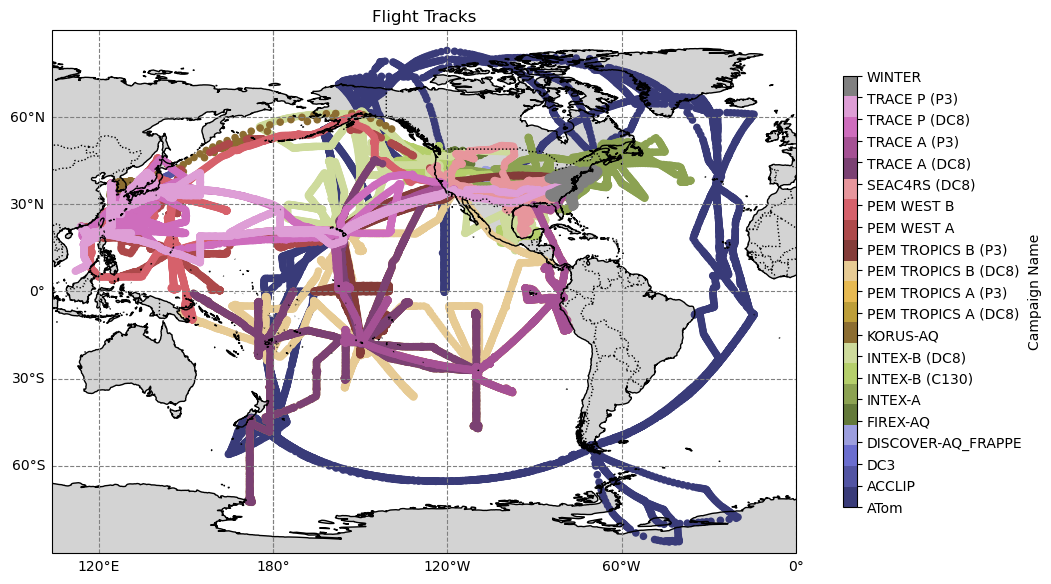

In [8]:
# Extract the colors from tab20b
tab20_colors = plt.cm.tab20b(np.linspace(0, 1, 20))

# Add a 21st color by interpolating (or define a custom color explicitly)
extra_color = np.array([[0.5, 0.5, 0.5, 1.0]])  # A neutral gray as an example
# extra_color = np.array([[0.0, 1.0, 1.0, 1.0]])  # Cyan: full green, full blue, no red
custom_colors = np.vstack([tab20_colors, extra_color])

# Create a custom ListedColormap
custom_tab20_21 = ListedColormap(custom_colors, name='custom_tab20_21')


# Example dictionary mapping numeric labels to custom string labels
label_mapping = {
    0: "ATom",
    1: "ACCLIP",
    2: "DC3",
    3: "DISCOVER-AQ_FRAPPE",
    4: "FIREX-AQ",
    5: "INTEX-A",
    6: "INTEX-B (C130)",
    7: "INTEX-B (DC8)",
    8: "KORUS-AQ",
    9: "PEM TROPICS A (DC8)",
    10: "PEM TROPICS A (P3)",
    11: "PEM TROPICS B (DC8)",
    12: "PEM TROPICS B (P3)",
    13: "PEM WEST A",
    14: "PEM WEST B",
    15: "SEAC4RS (DC8)",
    16: "TRACE A (DC8)",
    17: "TRACE A (P3)",
    18: "TRACE P (DC8)",
    19: "TRACE P (P3)",
    20: "WINTER",
    # Add more mappings as needed
}


# Replace numeric cluster labels with custom string labels
df['domain_label'] = df['domain_indicator'].map(label_mapping)

# Ensure there are no unmapped values
if df['domain_label'].isnull().any():
    raise ValueError("Some numeric labels do not have a corresponding string label in `label_mapping`.")
    

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=240)})
ax.set_extent([-136, 120, -90, 90], crs=ccrs.PlateCarree(central_longitude=240))

# Add basemap features
ax.coastlines(resolution='50m')
ax.add_feature(cfeature.BORDERS.with_scale('50m'), linestyle=':')
ax.add_feature(cfeature.LAND.with_scale('50m'), facecolor='lightgray')
ax.add_feature(cfeature.OCEAN.with_scale('50m'), facecolor='white')

# Add gridlines
gl = ax.gridlines(draw_labels=True, linestyle="--", color="gray")
gl.top_labels = gl.right_labels = False  # optional: turn off top/right labels for cleaner look

# Plot the data
sc = ax.scatter(
    df['Longitude_0'].values, 
    df['Latitude_0'].values, 
    c=df['domain_indicator'].values,  # Use numeric values for consistent coloring
    cmap=custom_tab20_21, 
    s=20, 
    transform=ccrs.PlateCarree()
)


# Update the colorbar to match the new number of labels
cbar = plt.colorbar(sc, ax=ax, orientation='vertical', pad=0.05, aspect=30, shrink=0.7)
cbar.set_label("Campaign Name")
cbar.set_ticks(range(len(label_mapping)))
cbar.set_ticklabels([label_mapping[i] for i in range(len(label_mapping))])

# Title and labels
ax.set_title("Flight Tracks")

# Save and display
plt.savefig(r"C:\Users\vwgei\Documents\PVOCAL\plots\standalone\domain_map.png")
plt.show()

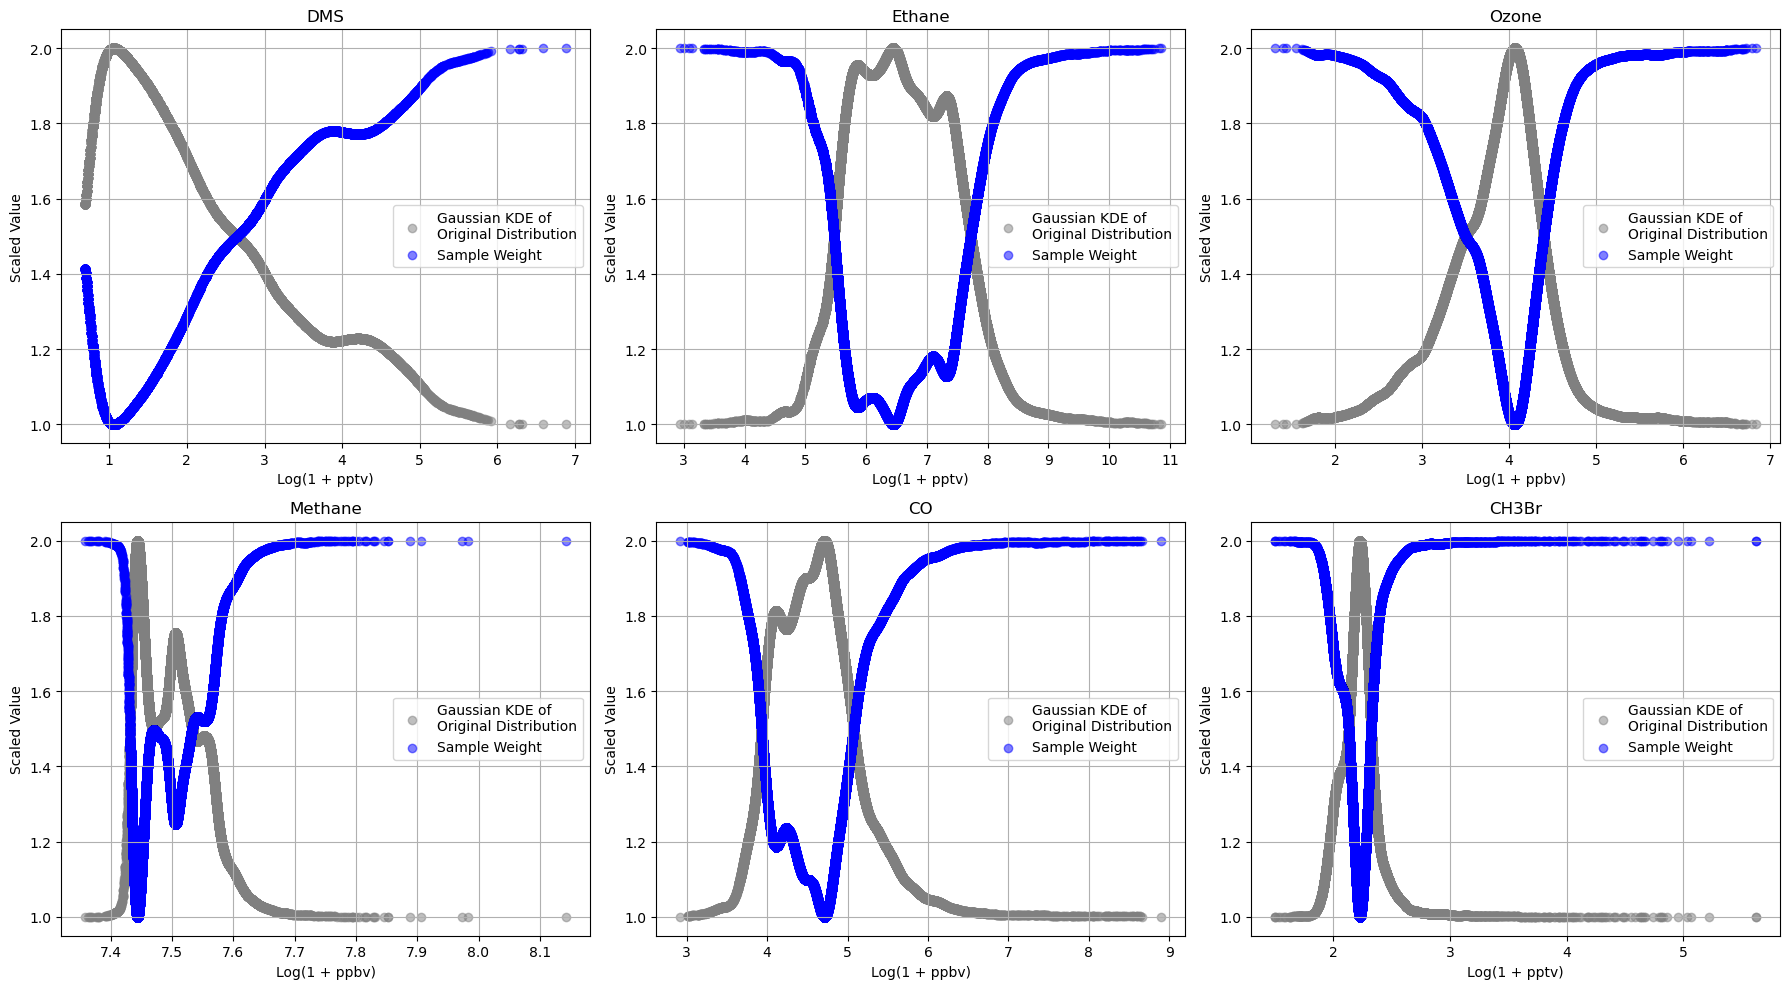

In [9]:
# df.replace(np.Inf, np.nan, inplace=True)
dms_nd, dms_sampweight, dms_kde = calculate_and_inverse_transform_kde(df['DMS'], transform=True, min_val=1, max_val=2)
ethane_nd, ethane_sampweight, ethane_kde = calculate_and_inverse_transform_kde(df['Ethane'], transform=True, min_val=1, max_val=2)
ozone_nd, ozone_sampweight, ozone_kde = calculate_and_inverse_transform_kde(df['O3'], transform=True, min_val=1, max_val=2)
methane_nd, methane_sampweight, methane_kde = calculate_and_inverse_transform_kde(df['CH4'], transform=True, min_val=1, max_val=2)
CO_nd, CO_sampweight, CO_kde = calculate_and_inverse_transform_kde(df['CO'], transform=True, min_val=1, max_val=2)
ch3br_nd, ch3br_sampweight, ch3br_kde = calculate_and_inverse_transform_kde(df['CH3Br'], transform=True, min_val=1, max_val=2)

# Step 5: Create 2x3 subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()  # Flatten the 2D array of axes for easy indexing

# List of compounds for easy iteration
compounds = [
    (dms_nd, dms_sampweight, dms_kde, 'DMS', 'pptv', 0),
    (ethane_nd, ethane_sampweight, ethane_kde, 'Ethane', 'pptv', 1),
    (ozone_nd, ozone_sampweight, ozone_kde, 'Ozone', 'ppbv', 2),
    (methane_nd, methane_sampweight, methane_kde, 'Methane', 'ppbv', 3),
    (CO_nd, CO_sampweight, CO_kde, 'CO', 'ppbv', 4),
    (ch3br_nd, ch3br_sampweight, ch3br_kde, 'CH3Br', 'pptv', 5)
]

# Plot each compound's data in the subplots
for i, (nd, sampweight, kde, label, unit, _) in enumerate(compounds):
    axes[i].scatter(nd, kde, color='gray', alpha=0.5, label='Gaussian KDE of\nOriginal Distribution')
    axes[i].scatter(nd, sampweight, color='blue', alpha=0.5, label='Sample Weight')
    axes[i].set_title(label)
    axes[i].set_xlabel(f'Log(1 + {unit})')
    axes[i].set_ylabel('Scaled Value')
    axes[i].legend()
    axes[i].grid()

plt.tight_layout()  # Adjust layout to prevent overlap
plt.savefig(f"C:/Users/vwgei/Documents/PVOCAL/plots/standalone/samp_weights_V4_scaled_log.png")
plt.show()

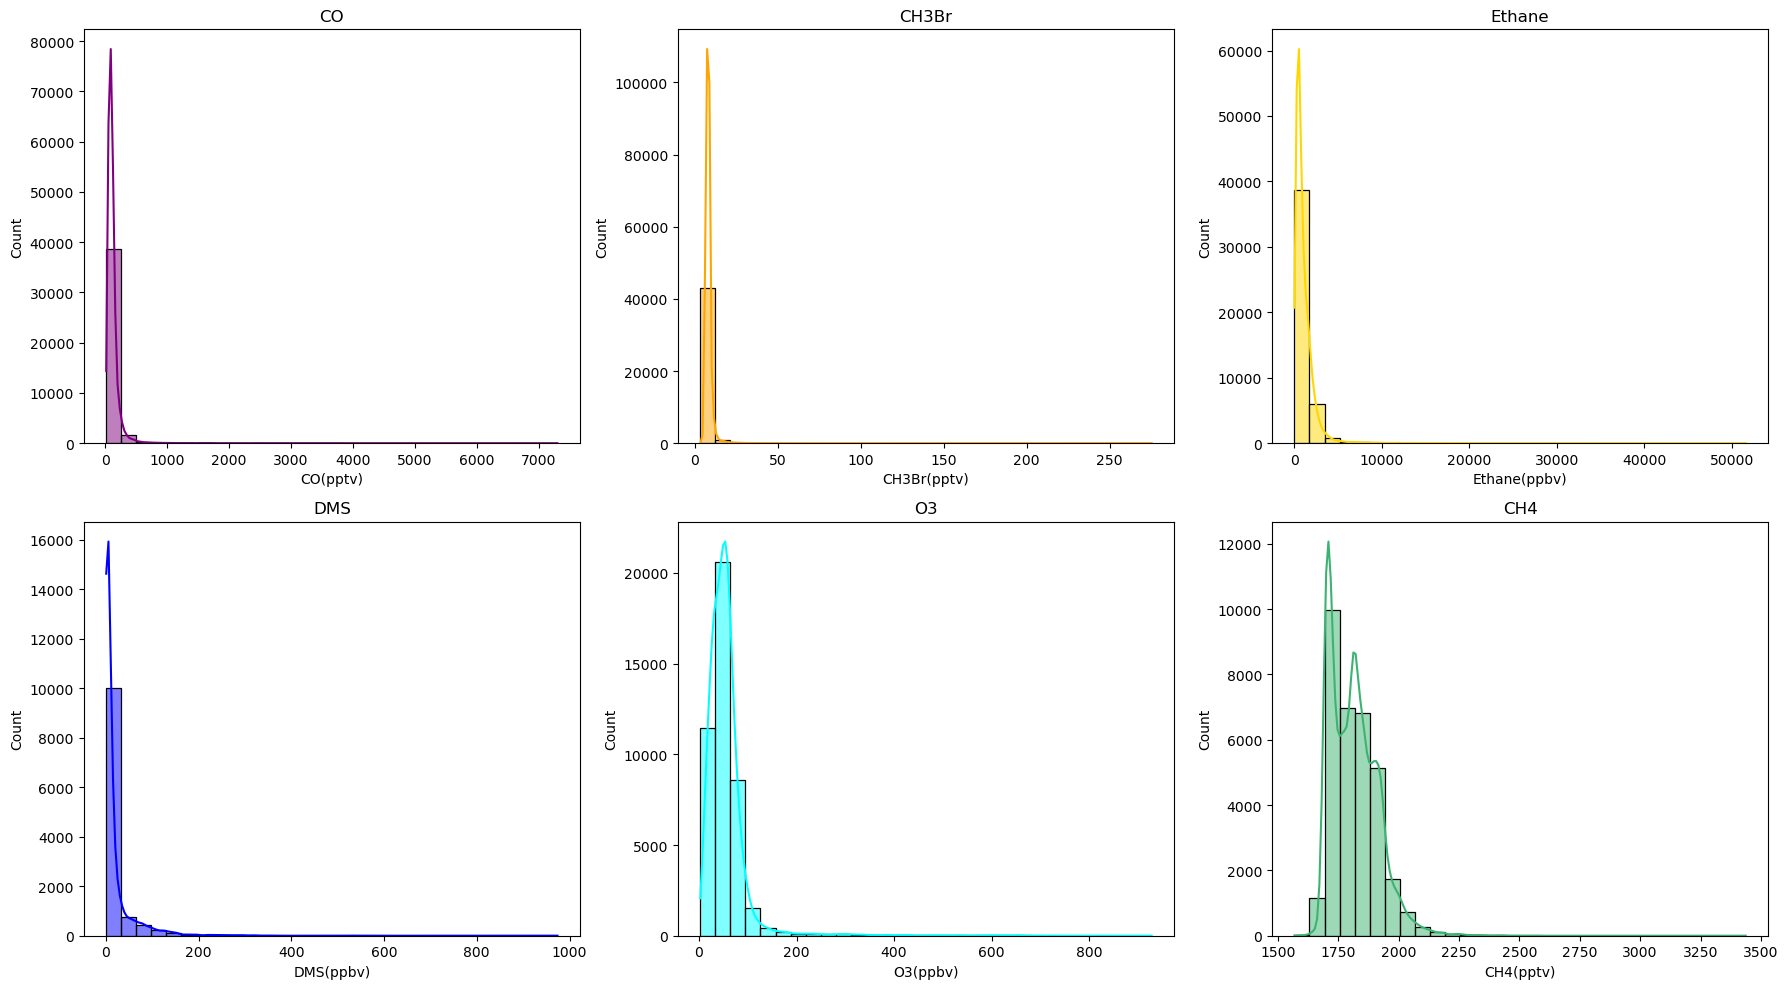

In [10]:
# List of columns to plot
columns = ["CO", "CH3Br", "Ethane", "DMS", "O3", "CH4",]

# Define colors for each variable
colors = ['purple', 'orange', 'gold', 'blue', 'cyan', 'mediumseagreen',]

units = ['(pptv)', '(pptv)', '(ppbv)', '(ppbv)', '(ppbv)', '(pptv)',]

# Create the subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()  # Flatten the 2D array of axes for easy indexing

# Plot each column in a separate subplot
for i, col in enumerate(columns):
    sns.histplot(data=df, x=col, kde=True, color=colors[i], ax=axes[i], bins=30)
    axes[i].set_title(col)  # Set title for each subplot
    axes[i].set_xlabel(col + units[i])

# Adjust layout to avoid overlap
plt.tight_layout()
plt.savefig(f"C:/Users/vwgei/Documents/PVOCAL/plots/standalone/ATS_distributions_V4.png")
plt.show()

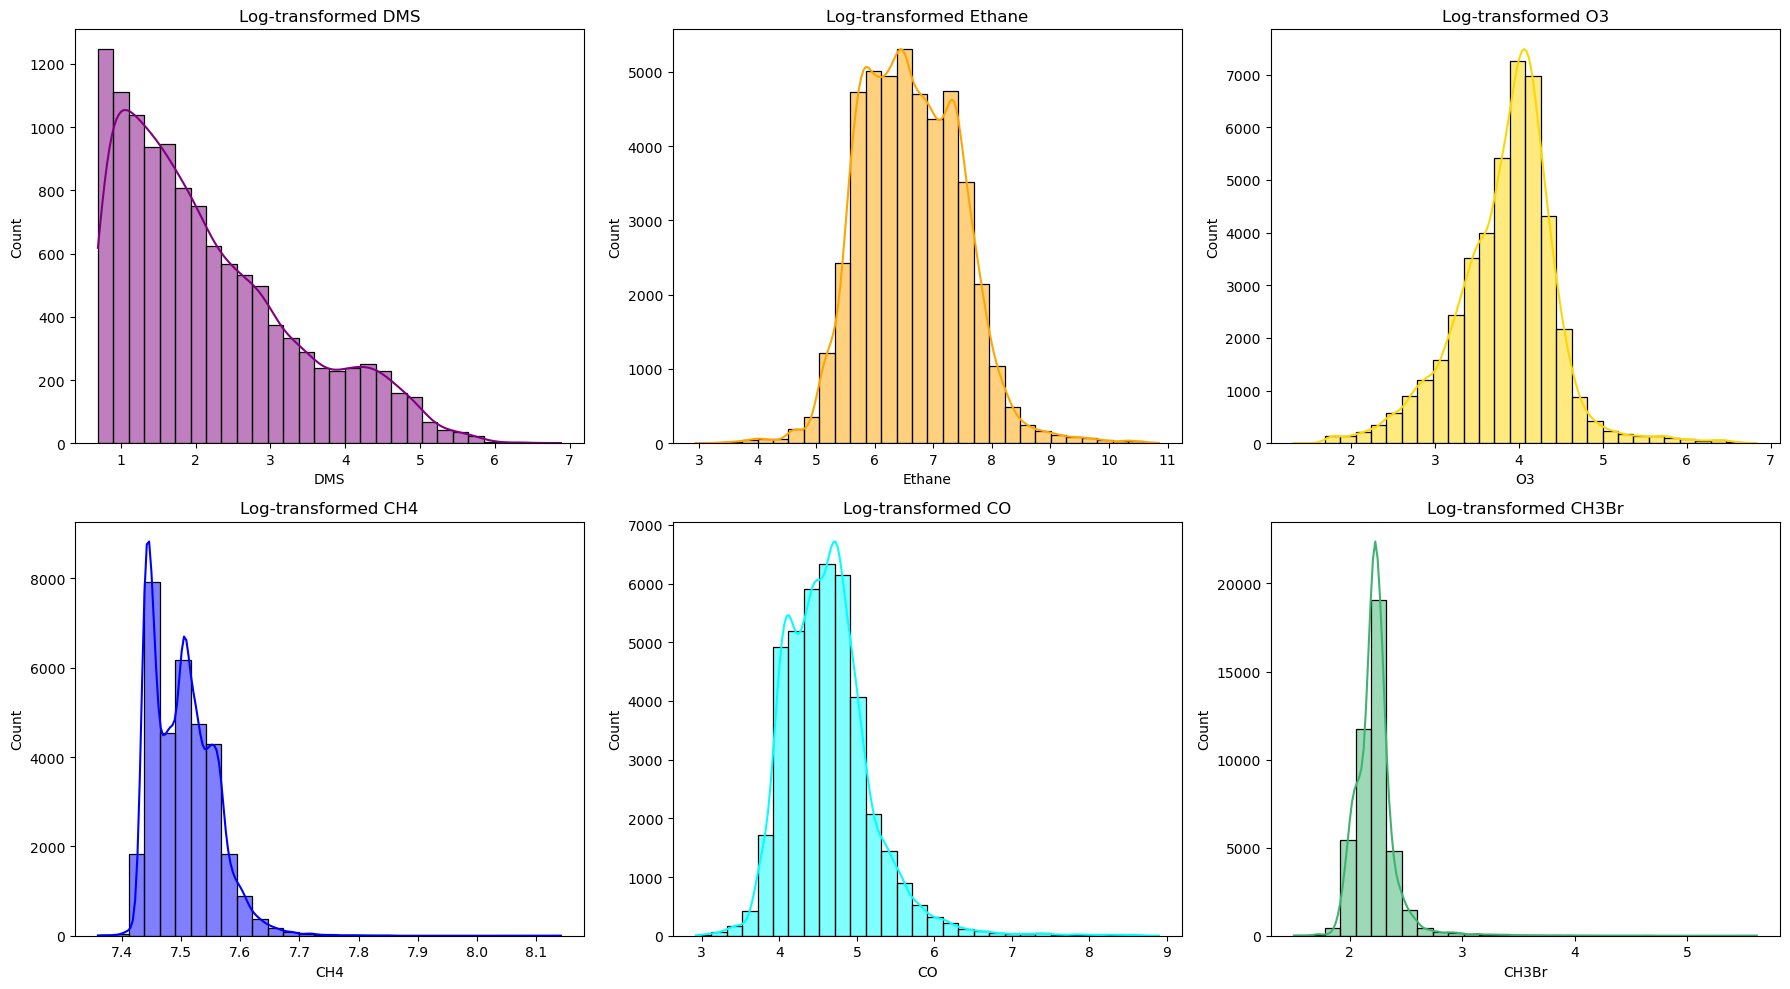

In [11]:
# List of columns to plot
columns = ["DMS", "Ethane", "O3", "CH4", "CO", "CH3Br"]

# Define colors for each variable
colors = ['purple', 'orange', 'gold', 'blue', 'cyan', 'mediumseagreen',]

# Create the subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()  # Flatten the 2D array of axes for easy indexing

# Plot each column in a separate subplot
for i, col in enumerate(columns):
    log_data = np.log1p(df[col])
    sns.histplot(x=log_data, kde=True, color=colors[i], ax=axes[i], bins=30)
    axes[i].set_title(f'Log-transformed {col}')  # Set title for each subplot

# Adjust layout to avoid overlap
plt.tight_layout()
plt.savefig(f"C:/Users/vwgei/Documents/PVOCAL/plots/standalone/ATS_distributions_V4_log.png")
plt.show()

In [12]:
pressure_columns = [f'Pressure_{i}' for i in range(-24, 1)]
potential_temperature_columns = [f'Potential_Temperature_{i}' for i in range(-24, 1)]
mixing_depth_columns = [f'Mixing_Depth_{i}' for i in range(24, 1)]
relative_humidity_columns = [f'Relative_Humidity_{i}' for i in range(-24, 1)]
specific_humidity_columns = [f'Specific_Humidity_{i}' for i in range(-24, 1)]
terrain_altitude_columns = [f'Terrain_Altitude_{i}' for i in range(-24, 1)]
solar_radiation_columns = [f'Solar_Radiation_{i}' for i in range(-24, 1)]
temperature_columns = [f'Temperature_C_{i}' for i in range(-24, 1)]
longitude_columns = [f'Longitude_{i}' for i in range(-24, 1)]
latitude_columns = [f'Latitude_{i}' for i in range(-24, 1)]
altitude_columns = [f'AltP_meters_{i}' for i in range(-24, 1)]

distance_ptp_columns = [f'Distance_ptp_{i}' for i in range(24,1)]
cumulative_dist_columns = [f'Cumulative_Dist_{i}' for i in range(24, 1)]
distance_fo_columns = [f'Dist_from_origin_{i}' for i in range(-24, 1)]
bearing_fo_columns = [f'bearings_from_origin_{i}' for i in range(-24, 1)]
bearing_ptp_columns = [f'bearings_ptp_{i}' for i in range(-24, 1)]


moisture_flux_columns = [f'Moisture_Flux_{i}' for i in range(-23, 0)]
# Dervied Fields
roc_columns = [f'Radius_of_Curvature_{i}' for i in range(-24, 0)]
ang_vel_columns = [f'Angular_Velocity_{i}' for i in range(-24, 0)]
moi_columns = [f'Moment_of_Inertia_{i}' for i in range(-24, 0)]
ang_momentum_columns = [f'Angular_Momentum_{i}' for i in range(-24, 0)]
vel_columns = [f'Velocity_{i}' for i in range(-24, 0)]
acc_columns = [f'Acceleration_{i}' for i in range(-24, -1)]
corr_acc_columns = [f'Coriolis_Accel_{i}' for i in range(-24, 0)]
rossby_num_columns = [f'Rossby_Number_{i}' for i in range(-24, 0)]
bv_columns = [f'Brunt_Vaisala_Freq_{i}' for i in range(-24, 0)]
div_columns = [f'Divergence_{i}' for i in range(-24, -1)]
moist_den_columns = [f'Density_Moist_{i}' for i in range (-24,0)]
reyn_num_columns = [f'Reynolds_Number_{i}' for i in range (-24,0)]
time_diff_seconds = [f'time_difference_seconds_{i}' for i in range (-24,0)]
hour_sin = [f'hour_sin_{i}' for i in range (-24,0)]
hour_cos = [f'hour_cos_{i}' for i in range (-24,0)]
month_sin = [f'month_sin_{i}' for i in range (-24,0)]
month_cos = [f'month_cos_{i}' for i in range (-24,0)]

lcl_columns = [f'LCL_{i}' for i in range(24, 1)]
rainfall_columns = [f'Rainfall_Estimate_{i}' for i in range(24, 1)]

In [13]:
# Specify Random State
rs = 64 #187 #76543 #9876 #76543#

In [14]:
# Function to perform KMeans clustering on a specific label subset and assign new cluster labels
def perform_kmeans_for_label(df, label, kmeans_k, rs, label_threshold):
    # Filter the dataframe for the current label
    subset = df[df['spatial_cluster'] == label]
    
    # Extract the coordinates for the subset
    coordinates_subset = subset[['Latitude_0', 'Longitude_0']]
    
    # Adjust longitude if needed
    coordinates_subset.loc[coordinates_subset['Longitude_0'] > 100, 'Longitude_0'] -= 360
    
    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=kmeans_k, random_state=rs)
    new_labels = kmeans.fit_predict(coordinates_subset)
    
    # # Assign a unique label to each cluster within this subset, starting from the threshold
    new_labels += label_threshold  # This shifts the labels to start at the threshold value

    # print(np.unique(new_labels))
    
    # Directly update the 'spatial_cluster' column in the original dataframe
    df.loc[subset.index, 'spatial_cluster'] = new_labels
    
    return df

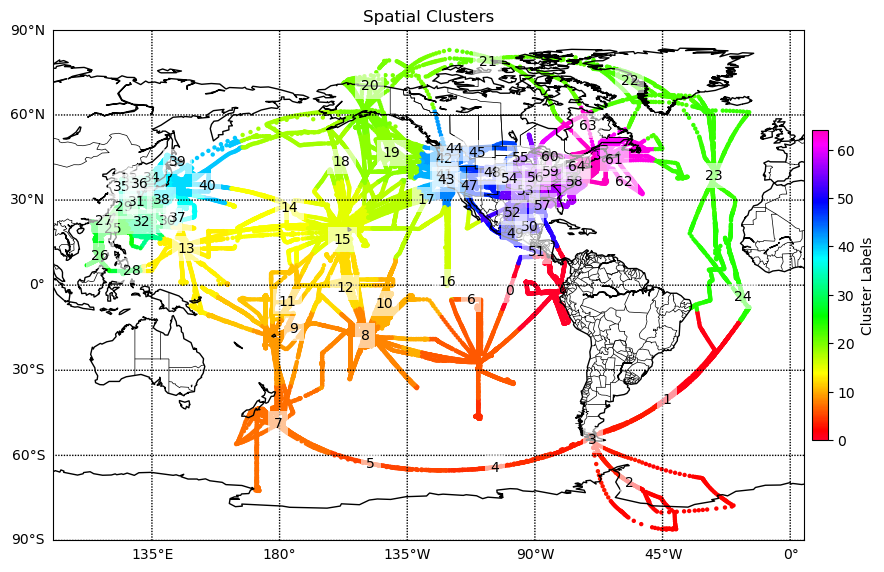

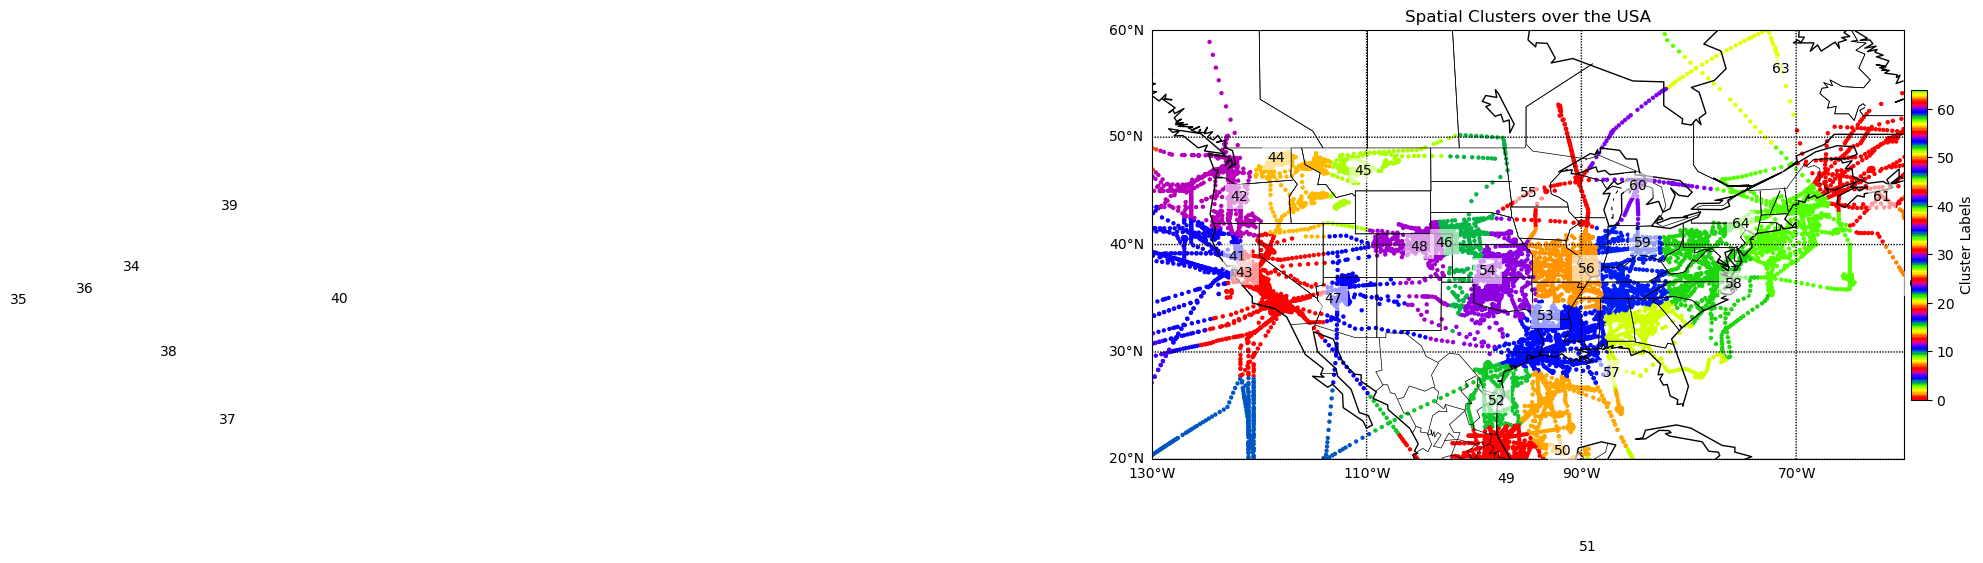

In [15]:
kmeans_k = 35

# Assuming data contains 'Latitude_0' and 'Longitude_0'
coordinates = df[['Latitude_0', 'Longitude_0']]
coordinates.loc[coordinates['Longitude_0'] > 100, 'Longitude_0'] -= 360

# Perform KMeans clustering
kmeans = KMeans(n_clusters=kmeans_k, random_state=rs)
df['spatial_cluster'] = kmeans.fit_predict(coordinates)


centroids = kmeans.cluster_centers_

map_center_lat = np.mean(df['Latitude_0'])
map_center_lon = np.mean(df['Longitude_0'])

angles = np.arctan2(centroids[:, 1] + 90, centroids[:, 0])
angles = np.degrees(angles) % 360

angles = (angles - 90) % 360

# Step 3: Sort clusters based on angles
sorted_indices = np.argsort(angles)
new_cluster_labels = np.zeros_like(df['spatial_cluster'])

# Step 4: Map old cluster labels to new sorted labels
for new_label, old_label in enumerate(sorted_indices):
    new_cluster_labels[df['spatial_cluster'] == old_label] = new_label

# Update the original spatial_cluster column with the sorted cluster labels
df['spatial_cluster'] = new_cluster_labels

sub_clusters = 4
# Threshold for new cluster labels
# Perform KMeans clustering for each label individually (5, 7, and 8)
labels_to_cluster = [14,15,17,18,25,26,27,28,30,32]
increment = range(kmeans_k, (kmeans_k + (sub_clusters * len(labels_to_cluster))), sub_clusters)
iterator = 0
for label in labels_to_cluster:
    df = perform_kmeans_for_label(df, label, sub_clusters, rs, increment[iterator])
    iterator += 1


# Create a mapping of unique cluster labels to sequential numbers
unique_labels = np.unique(df['spatial_cluster'])
label_mapping = {label: new_label for new_label, label in enumerate(unique_labels)}

# Apply the mapping to reassign labels
df['spatial_cluster'] = df['spatial_cluster'].replace(label_mapping)

# Step 5: Compute the centroids for the new sorted clusters
sorted_centroids = np.zeros((len(np.unique(df['spatial_cluster'])) , 2))

# Recompute centroids based on the new sorted cluster labels
for cluster in np.unique(df['spatial_cluster']):
    cluster_data = df[df['spatial_cluster'] == cluster]
    sorted_centroids[cluster] = [cluster_data['Latitude_0'].mean(), cluster_data['Longitude_0'].mean()]


lats = df["Latitude_0"].values
longs = df["Longitude_0"].values
longs = np.where(longs > 100, longs - 360, longs)
# cluster_labels = df['spatial_cluster']
cluster_labels = df['spatial_cluster']

mapcorners = [-260, -90, 5, 90]  # Full globe

# Create a map with custom boundaries
plt.figure(figsize=(10, 8))
m = Basemap(projection='cyl', llcrnrlon=mapcorners[0], llcrnrlat=mapcorners[1],
            urcrnrlon=mapcorners[2], urcrnrlat=mapcorners[3], lat_ts=20, resolution='c', lon_0=135)

# Draw coastlines, countries, and states
m.drawcoastlines()
m.drawcountries()
m.drawstates()

# Convert latitude and longitude to map coordinates
x, y = m(longs, lats)

# Plot points
scatter = m.scatter(x, y, s=10, c=cluster_labels, cmap='gist_rainbow', edgecolor='none')

# Loop through each unique cluster label and add text at the midpoint occurrence of that label
unique_labels = np.unique(cluster_labels)
for label in unique_labels:
    # Find all the indices where the cluster label occurs
    indices = np.where(cluster_labels == label)[0]
    # Find the index of the midpoint occurrence
    midpoint_index = indices[len(indices) // 2]
    # Add text label for this cluster at the midpoint location
    plt.text(x[midpoint_index], y[midpoint_index], str(label), fontsize=10, ha='center', va='center',
             bbox=dict(facecolor='white', edgecolor='none', alpha=0.6))

# Add colorbar
plt.colorbar(scatter, fraction=0.02, pad=0.01, label="Cluster Labels")

# Draw latitude and longitude grid lines
m.drawparallels(range(-90, 91, 30), labels=[1, 0, 0, 0], fontsize=10)  # Latitude lines
m.drawmeridians(range(-180, 181, 45), labels=[0, 0, 0, 1], fontsize=10)  # Longitude lines

plt.title('Spatial Clusters')
plt.savefig(r"C:\Users\vwgei\Documents\PVOCAL\plots\standalone\global_clusters.png")
plt.show()


# Define latitude and longitude boundaries for North America
na_mapcorners = [-130, 20, -60, 60]  # North America bounding box

# Create a figure for the North America zoomed-in map
plt.figure(figsize=(10, 8))
m_na = Basemap(projection='cyl', llcrnrlon=na_mapcorners[0], llcrnrlat=na_mapcorners[1],
               urcrnrlon=na_mapcorners[2], urcrnrlat=na_mapcorners[3], resolution='c')

# Draw coastlines, countries, and states
m_na.drawcoastlines()
m_na.drawcountries()
m_na.drawstates()

# Convert latitude and longitude to map coordinates for North America plot
x_na, y_na = m_na(longs, lats)

# Plot points for North America map
scatter_na = m_na.scatter(x_na, y_na, s=10, c=cluster_labels, cmap='prism', edgecolor='none')

# Accessing the values of the keys
values = np.array([label_mapping[key] for key in label_mapping.keys()])
usa_keys = values[values > (kmeans_k - 2)]


# Add text labels at midpoint for each cluster
for label in usa_keys:
    indices = np.where(cluster_labels == label)[0]
    midpoint_index = indices[len(indices) // 2]
    plt.text(x_na[midpoint_index], y_na[midpoint_index], str(label), fontsize=10, ha='center', va='center',
             bbox=dict(facecolor='white', edgecolor='none', alpha=0.6))

# Add colorbar for the North America map
plt.colorbar(scatter_na, fraction=0.02, pad=0.01, label="Cluster Labels")

# Draw latitude and longitude grid lines for North America map
m_na.drawparallels(range(20, 61, 10), labels=[1, 0, 0, 0], fontsize=10)  # Latitude lines
m_na.drawmeridians(range(-130, -59, 20), labels=[0, 0, 0, 1], fontsize=10)  # Longitude lines

# Title and save the zoomed-in plot
plt.title('Spatial Clusters over the USA')
plt.savefig(r"C:\Users\vwgei\Documents\PVOCAL\plots\standalone\USA_clusters.png")
plt.show()


# # Define latitude and longitude boundaries for the Japan region
# japan_mapcorners = [122, 24, 154, 46]  # Japan bounding box

# # Create a figure for the Japan zoomed-in map
# plt.figure(figsize=(10, 8))
# m_japan = Basemap(projection='cyl', llcrnrlon=japan_mapcorners[0], llcrnrlat=japan_mapcorners[1],
#                   urcrnrlon=japan_mapcorners[2], urcrnrlat=japan_mapcorners[3], resolution='c')

# # Draw coastlines, countries, and states
# m_japan.drawcoastlines()
# m_japan.drawcountries()

# # Convert latitude and longitude to map coordinates for Japan plot
# x_japan, y_japan = m_japan(longs, lats)

# # Plot points for Japan map
# scatter_japan = m_japan.scatter(x_japan, y_japan, s=10, c=cluster_labels, cmap='prism', edgecolor='none')

# # Add text labels at midpoint for each cluster in the Japan region
# for label in unique_labels:
#     indices = np.where(cluster_labels == label)[0]
#     # Filter for points within the Japan bounding box
#     midpoint_index = next((i for i in indices if (
#         japan_mapcorners[0] <= longs[i] <= japan_mapcorners[2] and 
#         japan_mapcorners[1] <= lats[i] <= japan_mapcorners[3])), None)
    
#     if midpoint_index is not None:
#         plt.text(x_japan[midpoint_index], y_japan[midpoint_index], str(label), fontsize=10, ha='center', va='center',
#                  bbox=dict(facecolor='white', edgecolor='none', alpha=0.6))

# # Add colorbar for the Japan map
# plt.colorbar(scatter_japan, fraction=0.02, pad=0.01, label="Cluster Labels")

# # Draw latitude and longitude grid lines for Japan map
# m_japan.drawparallels(range(24, 47, 5), labels=[1, 0, 0, 0], fontsize=10)  # Latitude lines
# m_japan.drawmeridians(range(122, 155, 5), labels=[0, 0, 0, 1], fontsize=10)  # Longitude lines

# # Title and save the zoomed-in plot
# plt.title('Spatial Clusters in Japan')
# plt.savefig(r"C:\Users\vwgei\Documents\PVOCAL\plots\standalone\Japan_clusters.png")
# plt.show()

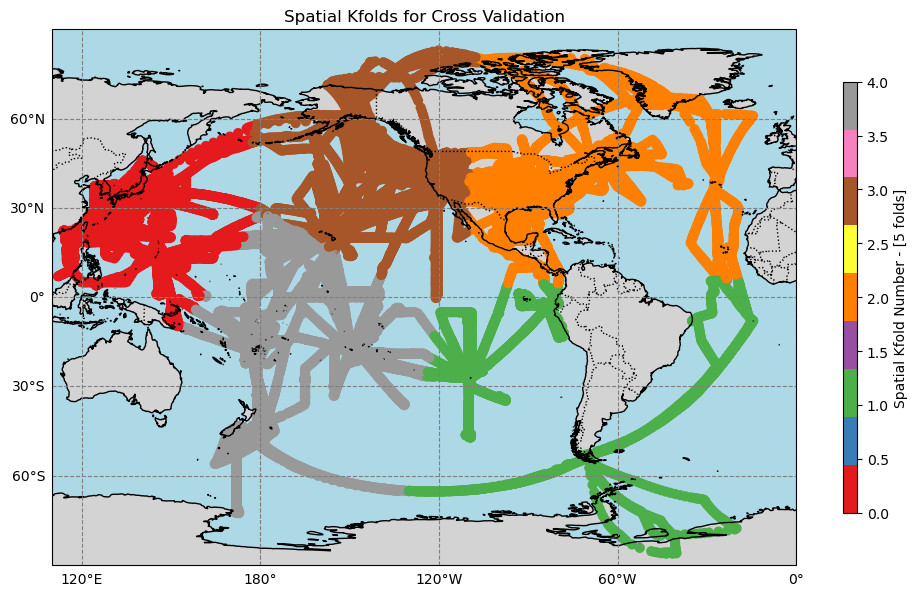

In [16]:
adjusted_longitude = df['Longitude_0'].apply(lambda x: x - 360 if x > 100 else x)

df['kfold_Longitude'] = adjusted_longitude

coordinates = list(zip(df['kfold_Longitude'], df['Latitude_0']))  # Extract coordinates
num_k_spatial_splits = 5
df = spatial_kfold_split(df, coordinates, n_splits=num_k_spatial_splits)

# Create a plot with a Cartopy basemap
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=240)})
ax.set_extent([-130, 120, -90, 90], crs=ccrs.PlateCarree(central_longitude=240))

# Add basemap features
# ax.set_global()
ax.coastlines(resolution='50m')
ax.add_feature(cfeature.BORDERS.with_scale('50m'), linestyle=':')
ax.add_feature(cfeature.LAND.with_scale('50m'), facecolor='lightgray')
ax.add_feature(cfeature.OCEAN.with_scale('50m'), facecolor='lightblue')

# Add gridlines
gl = ax.gridlines(draw_labels=True, linestyle="--", color="gray")
gl.top_labels = gl.right_labels = False  # optional: turn off top/right labels for cleaner look

# Plot the data
sc = ax.scatter(df['Longitude_0'].values, df['Latitude_0'].values, c=df['kfold_cluster'].values, cmap='Set1', s=40, transform=ccrs.PlateCarree())

# Add a colorbar
cbar = plt.colorbar(sc, ax=ax, orientation='vertical', pad=0.05, aspect=30, shrink=0.7)
cbar.set_label(f'Spatial Kfold Number - [{num_k_spatial_splits} folds]')

# Title and labels
ax.set_title("Spatial Kfolds for Cross Validation")
plt.savefig(r"C:\Users\vwgei\Documents\PVOCAL\plots\standalone\kfold_clusters.png")
plt.show()

In [17]:
# Define constants
kmeans_dist = 100
# rs = 42  # Set a random seed for reproducibility if needed

# Convert lat/lon to radians for both points and centroids
coordinates = df[['Latitude_0', 'Longitude_0']].copy()
coordinates.loc[coordinates['Longitude_0'] > 100, 'Longitude_0'] -= 360
coords_radians = np.radians(coordinates.values)

# Perform KMeans clustering
kmeans = KMeans(n_clusters=kmeans_dist, random_state=rs)
kmeans.fit(coordinates)
centroids = kmeans.cluster_centers_
centroids_radians = np.radians(centroids)  # Convert centroids to radians

# Haversine function
def haversine(lat_lon1, lat_lon2):
    R = 6371  # Radius of Earth in meters
    dlat = lat_lon2[0] - lat_lon1[0]
    dlon = lat_lon2[1] - lat_lon1[1]
    a = np.sin(dlat / 2)**2 + np.cos(lat_lon1[0]) * np.cos(lat_lon2[0]) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

# Parallelized function to calculate distances from one point to all centroids
def distance_to_centroids(point, centroids):
    return [haversine(point, centroid) for centroid in centroids]

# Run in parallel: calculate distance from each point to all centroids
distances = Parallel(n_jobs=10)(delayed(distance_to_centroids)(coords_radians[i], centroids_radians) for i in range(len(coords_radians)))
dist_matrix = np.array(distances)

# Optional: Compute minimum and mean distance to centroids as features
df['min_distance_to_cluster_centroids'] = dist_matrix.min(axis=1)
df['mean_distance_to_cluster_centroids'] = dist_matrix.mean(axis=1)

In [18]:
world_cites = pd.read_csv(r"C:\Users\vwgei\Documents\PVOCAL\data\worldcities.csv")
top_1000 = world_cites.sort_values('population', ascending=False).iloc[:1000]

top_1000_ll = top_1000[['lat', 'lng']]
top_1000_ll.loc[top_1000_ll['lng'] > 100, 'lng'] -= 360
top_1000_radians = np.radians(top_1000_ll.values)

# Run in parallel: calculate distance from each point to all centroids
distances_cities = Parallel(n_jobs=10)(delayed(distance_to_centroids)(coords_radians[i], top_1000_radians) for i in range(len(coords_radians)))
dist_matrix_cities = np.array(distances_cities)

# Optional: Compute minimum and mean distance to centroids as features
df['min_distance_to_t1000_cities'] = dist_matrix_cities.min(axis=1)
df['mean_distance_to_t1000_cities'] = dist_matrix_cities.mean(axis=1)

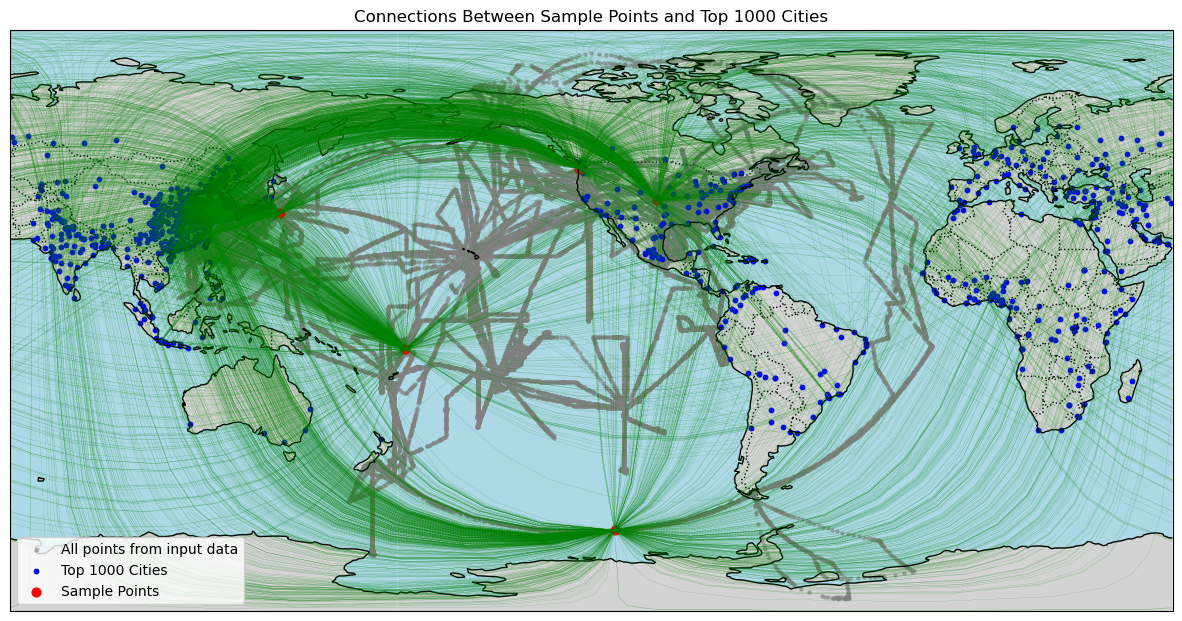

In [19]:
df_copy = df[['Latitude_0', 'Longitude_0', 'kfold_cluster']].copy()
df_copy.loc[df_copy['Longitude_0'] > 100, 'Longitude_0'] -= 360
sample_points = df_copy.sample(n=5, replace=True, random_state=42)
# Convert sample points to radians (assuming they contain 'lat' and 'lng' columns)
sample_points_ll = sample_points[['Latitude_0', 'Longitude_0']]
sample_points_ll.loc[sample_points_ll['Latitude_0'] > 100, 'Longitude_0'] -= 360
sample_points_radians = np.radians(sample_points_ll.values)

# Calculate distance matrix for each of the 7 sample points to each of the top 100 cities
distances_sample = [
    distance_to_centroids(sample_point, top_1000_radians) 
    for sample_point in sample_points_radians
]

# Convert to numpy array for matrix operations
dist_matrix_sample = np.array(distances_sample)

# Set up the map projection
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=240))
ax.set_global()

# Add coastlines and other map features
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

# Plot all points from df in gray
ax.scatter(
    df['Longitude_0'],
    df['Latitude_0'],
    color='gray',
    s=5,
    alpha=0.5,
    label='All points from input data',
    transform=ccrs.PlateCarree()
)

# Plot top 100 cities as blue dots
ax.scatter(
    top_1000_ll['lng'],
    top_1000_ll['lat'],
    color='blue',
    s=10,
    label='Top 1000 Cities',
    transform=ccrs.PlateCarree()
)

# Plot the 7 sample points as red dots
ax.scatter(
    sample_points_ll['Longitude_0'],
    sample_points_ll['Latitude_0'],
    color='red',
    s=40,
    label='Sample Points',
    transform=ccrs.PlateCarree()
)

# Draw lines connecting each sample point to each top 100 city
for sample_point in sample_points_radians:
    sample_lat, sample_lng = np.degrees(sample_point)
    for city_lat, city_lng in top_1000_ll.values:
        ax.plot(
            [sample_lng, city_lng],
            [sample_lat, city_lat],
            color='green',
            linewidth=0.1,
            linestyle='--',
            transform=ccrs.Geodetic()
        )

# Add a legend and title
plt.legend(loc='lower left')
plt.title('Connections Between Sample Points and Top 1000 Cities')
plt.show()

In [20]:
# Step 1: Define Reference Points
# A) Average dataset center (mean latitude and longitude)
# center_lat = df['Latitude_0'].mean()
# center_lon = df['Longitude_0'].mean()
# dataset_center = (center_lat, center_lon)

point_90_lonmin = (90, -247.988)

point_neg90_lonmin = (-90, -247.988)

# point_90_neg180 = (90, -143.7789)

# point_neg90_neg180 = (-90, -143.7789)

point_90_lonmax = (90, -14.42)

point_neg90_lonmax = (-90, -14.42)

# List of reference points
reference_points = [point_90_lonmin, point_neg90_lonmin, point_90_lonmax, point_neg90_lonmax]

# Step 2: Define Function to Calculate Distances to Each Reference Point
def calculate_distances_to_references(point):
    """Calculate the distances from a given point to each reference point."""
    distances = [geodesic(point, ref_point).kilometers for ref_point in reference_points]
    return distances

# Step 3: Run Distance Calculations in Parallel for Each Point in `df`
# Prepare points from df as a list of tuples (lat, lon) for each point
points = list(zip(df['Latitude_0'], df['Longitude_0']))

# Parallel computation of distance matrix
distances_extent_corners = Parallel(n_jobs=-1)(
    delayed(calculate_distances_to_references)(point) for point in points
)
dist_matrix_extents = np.array(distances_extent_corners)

# Step 4: Compute Minimum and Mean Distances for Each Point and Add to `df`
df['min_distance_to_extent_corners'] = dist_matrix_extents.min(axis=1)
df['mean_distance_to_extent_corners'] = dist_matrix_extents.mean(axis=1)

In [21]:
# Step 1: Define Reference Points
# A) Average dataset center (mean latitude and longitude)
# point_90_lonmin = (90, -247.988)

# point_neg90_lonmin = (-90, -247.988)

point_90_neg180 = (90, -180)

point_0_neg180 = (0, -180)

point_neg90_neg180 = (-90, -180)

# List of reference points
reference_points = [point_90_neg180, point_0_neg180, point_neg90_neg180]

# Step 2: Define Function to Calculate Distances to Each Reference Point
def calculate_distances_to_references(point):
    """Calculate the distances from a given point to each reference point."""
    distances = [geodesic(point, ref_point).kilometers for ref_point in reference_points]
    return distances

# Step 3: Run Distance Calculations in Parallel for Each Point in `df`
# Prepare points from df as a list of tuples (lat, lon) for each point
points = list(zip(df['Latitude_0'], df['Longitude_0']))

# Parallel computation of distance matrix
distances_antimeridian = Parallel(n_jobs=-1)(
    delayed(calculate_distances_to_references)(point) for point in points
)
distances_antimeridian = np.array(distances_antimeridian)

# Step 4: Compute Minimum and Mean Distances for Each Point and Add to `df`
df['min_distance_to_antimeridian'] = distances_antimeridian.min(axis=1)
df['mean_distance_to_antimeridian'] = distances_antimeridian.mean(axis=1)

In [22]:
df.to_csv(r"C:\Users\vwgei\Documents\PVOCAL\data\V4\df_preprocessed.csv", index=False)

In [23]:
tt_split = 0.2

epsilon = {'CO' : 4.5, 'CH3Br' : 5, 'O3' : 1, 'DMS' : 1, 'Ethane' : 4.5, 'CH4' : 1.25}
alpha = {'CO' : 0.55, 'CH3Br' : 0.50, 'O3' : 0.50, 'DMS' : 0.45, 'Ethane' : 0.55, 'CH4' : 0.45}
log_transform = {'CO' : False, 'CH3Br' : False, 'O3' : False, 'DMS' : False, 'Ethane' : False, 'CH4' : False}
sample_weighting = {'CO' : True, 'CH3Br' : True, 'O3' : True, 'DMS' : True, 'Ethane' : True, 'CH4' : True}
m_w_f_l = {'CO' : 0.0004, 'CH3Br' : 0.002, 'O3' : 0.0004, 'DMS' : 0.001, 'Ethane' : 0.0002, 'CH4' : 0.001}

sub_member_size = 25

GMI_flag = True
tree_plotting = False
show_plots_flag = True

# The interval new sample weights will be scaled to
new_min = 1
new_max = 2

# 'min_distance_to_cluster_centroids'
input_features = [
    'mean_distance_to_cluster_centroids', 'mean_distance_to_antimeridian', 'mean_distance_to_t1000_cities',
    'min_distance_to_t1000_cities', 'min_distance_to_cluster_centroids', 'min_distance_to_extent_corners',
    'Specific_Humidity_0', 'Potential_Temperature_0', 'mean_lcl', 'bearings_from_origin_-24',
    'sum_moisture_flux', 'mean_mixing_depth', 'sum_solar_radiation', 'domain_indicator', 'time_difference_seconds_0',
]

In [24]:
label

64

In [25]:
# df[bv_columns] = df[bv_columns].fillna(0)

In [26]:
ats = ['CO', 'Ethane'] # 'CO', 'Ethane', 'O3', 'CH4', 'DMS', 'CH3Br'

In [27]:
r2_scores = []
mse_scores = []

cluster_stats = {}

models_rf = {}
models_lr = {}
best_models = {}  # To store the best models for each region

In [28]:
PASTEL_train = pd.DataFrame()
PASTEL_test = pd.DataFrame()

Current Model Run: CO
Global model fit in progress...
Complete!
Random Forest Out of Bag Score: 
0.621
Q-statistic (PBV): 0.1123656040834462, SSW: 1372932587.700659, SST: 1546732071.2408805
('WARNING: ', 8, ' is an island (no neighbors)')
('WARNING: ', 173, ' is an island (no neighbors)')
('WARNING: ', 220, ' is an island (no neighbors)')
('WARNING: ', 636, ' is an island (no neighbors)')
('WARNING: ', 782, ' is an island (no neighbors)')
('WARNING: ', 986, ' is an island (no neighbors)')
('WARNING: ', 1249, ' is an island (no neighbors)')
('WARNING: ', 1398, ' is an island (no neighbors)')
('WARNING: ', 1679, ' is an island (no neighbors)')
('WARNING: ', 1956, ' is an island (no neighbors)')
('WARNING: ', 2147, ' is an island (no neighbors)')
('WARNING: ', 2558, ' is an island (no neighbors)')
('WARNING: ', 2585, ' is an island (no neighbors)')
('WARNING: ', 2664, ' is an island (no neighbors)')
('WARNING: ', 2761, ' is an island (no neighbors)')
('WARNING: ', 2856, ' is an island (no

<Figure size 1000x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 800x600 with 0 Axes>

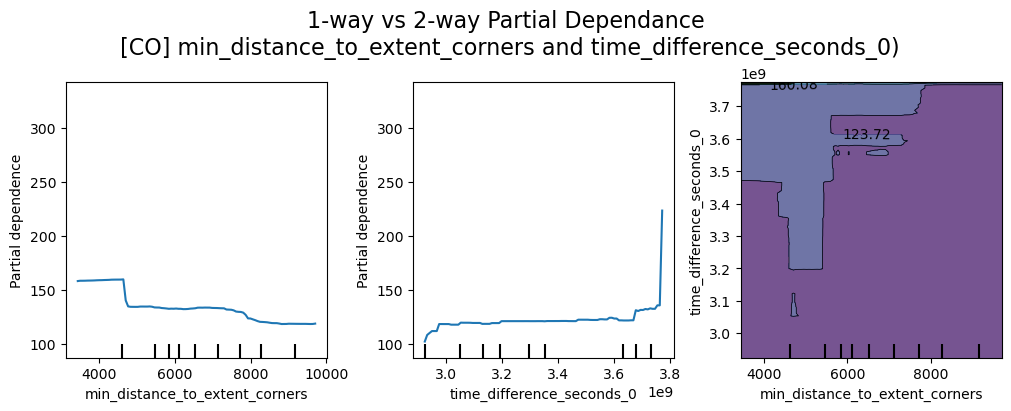

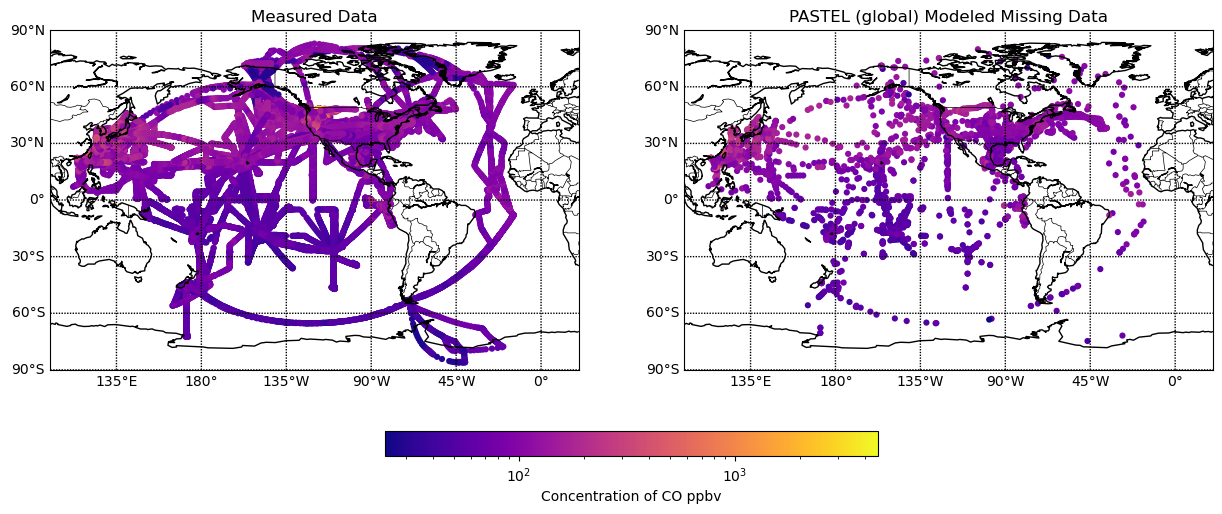

Processing ensemble member: 0
Cluster sample size: 809
	Training ensamble sub-member: [0]
	Training ensamble sub-member: [1]
	Training ensamble sub-member: [2]
	Training ensamble sub-member: [3]
	Training ensamble sub-member: [4]
	Training ensamble sub-member: [5]
	Training ensamble sub-member: [6]
	Training ensamble sub-member: [7]
	Training ensamble sub-member: [8]
	Training ensamble sub-member: [9]
	Training ensamble sub-member: [10]
	Training ensamble sub-member: [11]
	Training ensamble sub-member: [12]
	Training ensamble sub-member: [13]
	Training ensamble sub-member: [14]
	Training ensamble sub-member: [15]
	Training ensamble sub-member: [16]
	Training ensamble sub-member: [17]
	Training ensamble sub-member: [18]
	Training ensamble sub-member: [19]
	Training ensamble sub-member: [20]
	Training ensamble sub-member: [21]
	Training ensamble sub-member: [22]
	Training ensamble sub-member: [23]
	Training ensamble sub-member: [24]
('WARNING: ', 51, ' is an island (no neighbors)')
('WAR

<Figure size 640x480 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 800x600 with 0 Axes>

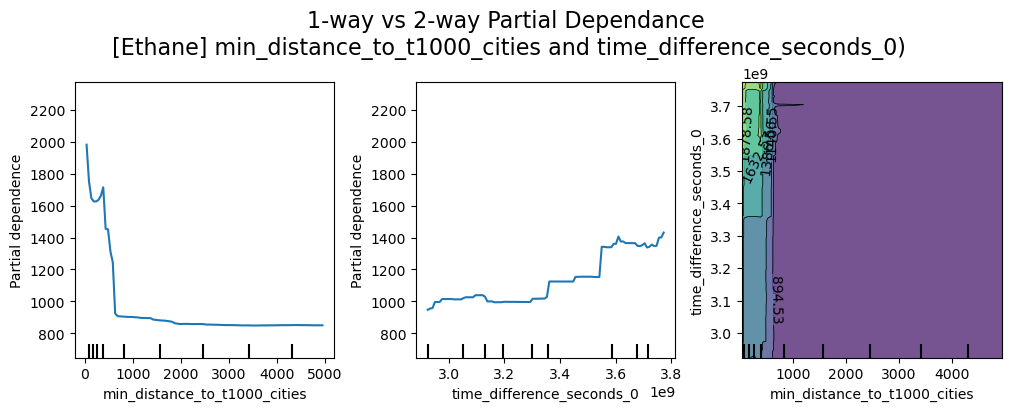

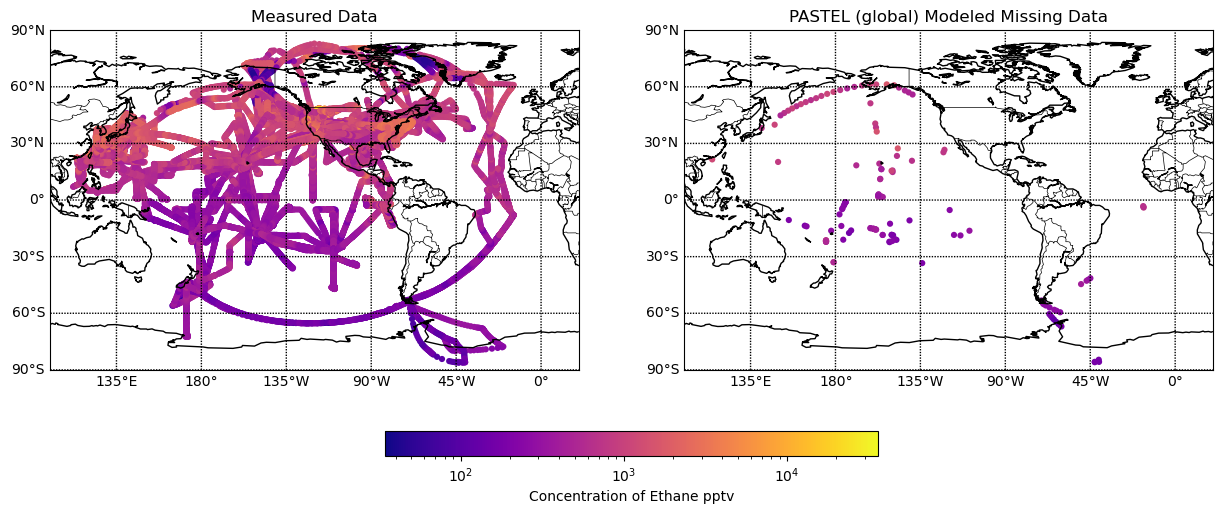

Processing ensemble member: 0
Cluster sample size: 871
	Training ensamble sub-member: [0]
	Training ensamble sub-member: [1]
	Training ensamble sub-member: [2]
	Training ensamble sub-member: [3]
	Training ensamble sub-member: [4]
	Training ensamble sub-member: [5]
	Training ensamble sub-member: [6]
	Training ensamble sub-member: [7]
	Training ensamble sub-member: [8]
	Training ensamble sub-member: [9]
	Training ensamble sub-member: [10]
	Training ensamble sub-member: [11]
	Training ensamble sub-member: [12]
	Training ensamble sub-member: [13]
	Training ensamble sub-member: [14]
	Training ensamble sub-member: [15]
	Training ensamble sub-member: [16]
	Training ensamble sub-member: [17]
	Training ensamble sub-member: [18]
	Training ensamble sub-member: [19]
	Training ensamble sub-member: [20]
	Training ensamble sub-member: [21]
	Training ensamble sub-member: [22]
	Training ensamble sub-member: [23]
	Training ensamble sub-member: [24]
('WARNING: ', 133, ' is an island (no neighbors)')
('WA

<Figure size 640x480 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [29]:
for i in range(len(ats)):
    labelparts = ats[i].split('_')

    Metrics_table_test = pd.DataFrame()
    Metrics_table_train = pd.DataFrame()

    if (len(labelparts) == 3):
        label = labelparts[1]
    else:
        label = labelparts[0]

    # global_model_save_path = os.path.join("C:\\", "Users", "vwgei", "Documents", "PVOCAL", "ensemble", "global_model", f"V4_{label}", "Global")
    global_plot_save_path = os.path.join("C:\\", "Users", "vwgei", "Documents", "PVOCAL", "ensemble", "global_models", f"V4_{label}", "plots")
    global_data_save_path = os.path.join("C:\\", "Users", "vwgei", "Documents", "PVOCAL","ensemble", "global_models", f"V4_{label}", "data")
    global_model_save_path = os.path.join("C:\\", "Users", "vwgei", "Documents", "PVOCAL", "ensemble", "global_models", f"V4_{label}", "models") 
    os.makedirs(global_plot_save_path, exist_ok=True)
    os.makedirs(global_data_save_path, exist_ok=True)
    os.makedirs(global_model_save_path, exist_ok=True)

    print(f"Current Model Run: {label}")

    var_of_int = ats[i]

    # Match unit labels to VOC
    if var_of_int == 'DMS':# or var_of_int == 'CH4':
        unit_label = "pptv"
        GMI_flag = False
    elif var_of_int == 'CH4':# or var_of_int == 'CH4':
        unit_label = "ppbv"
        GMI_flag = True
    elif var_of_int == 'CO': # or var_of_int == 'CO':
        unit_label = "ppbv"
        GMI_flag = True
    elif var_of_int == 'O3': # or var_of_int == 'O3':
        unit_label = "ppbv"
        GMI_flag = True
    else:
        unit_label = "pptv"
        if var_of_int == 'Ethane': # or var_of_int == 'Ethane_WAS':
            GMI_flag = True
        if var_of_int == 'CH3Br': # or var_of_int == 'CH3Br_WAS': 
            GMI_flag = True

    # Begin Global Model Code
    global_subset = df.dropna(subset=var_of_int)
    global_subset_i = df[~df.index.isin(global_subset.index)]

    global_subset = global_subset.replace([np.inf, -np.inf], np.nan)
    global_subset_i = global_subset_i.replace([np.inf, -np.inf], np.nan)

    global_subset = global_subset.dropna(subset=input_features)
    global_subset_i = global_subset_i.dropna(subset=input_features)

    global_columns = global_subset.columns

    prediction_var = global_subset[var_of_int]
    prediction_var_i = global_subset_i[var_of_int]

    if log_transform[label]:
        prediction_var = np.log1p(prediction_var) # Log Transform
        prediction_var_i = np.log1p(prediction_var_i) # Log Transform

    predictionBaseVars = global_subset[input_features]
    predictionBaseVars_i = global_subset_i[input_features]
    try:
        X_train, X_test, y_train, y_test = train_test_split(predictionBaseVars, prediction_var, 
                                                        test_size=tt_split, random_state=None,
                                                        stratify=global_subset['spatial_cluster'])
    except ValueError:
        print("WARNING! Cannot stratify train test split. Clusters too small...")
        print("Performing normal train test split")
        X_train, X_test, y_train, y_test = train_test_split(predictionBaseVars, prediction_var, 
                                                test_size=tt_split, random_state=None,
                                                )

    # global_split_save_path = os.path.join("C:\\", "Users", "vwgei", "Documents", "PVOCAL", "ensemble")
    # os.makedirs(global_split_save_path, exist_ok=True)

    # Save so we can use in the regional model later!
    with open(os.path.join(global_data_save_path, f"{label}_global_X_train.pkl"), "wb") as f:
        pickle.dump(X_train, f)
    with open(os.path.join(global_data_save_path, f"{label}_global_X_test.pkl"), "wb") as f:
        pickle.dump(X_test, f)
    with open(os.path.join(global_data_save_path, f"{label}_global_y_train.pkl"), "wb") as f:
        pickle.dump(y_train, f)
    with open(os.path.join(global_data_save_path, f"{label}_global_y_test.pkl"), "wb") as f:
        pickle.dump(y_test, f)

    global_scaler = StandardScaler()
    X_train_scaled = global_scaler.fit_transform(X_train)
    X_test_scaled = global_scaler.transform(X_test)

    train_nd, samp_weights_train, train_kde = calculate_and_inverse_transform_kde(y_train, min_val=new_min, max_val=new_max)

    # Plot the sample weights
    plt.figure(figsize=(10, 6))
    plt.scatter(train_nd, samp_weights_train, color='cornflowerblue', alpha=0.5, label=label)
    plt.title(f'{label} Sample Weights vs Concentration')
    plt.xlabel(f'{label} {unit_label}')
    plt.ylabel(f'Sample Weight')
    # plt.legend()
    plt.grid()
    os.makedirs(global_plot_save_path, exist_ok=True)  # Create the directory if it doesn't exist
    plt.savefig(os.path.join(global_plot_save_path, f"sampweight_global.png"))
    plt.clf()

    # Global Sample Size
    n = len(global_subset)


    PASTEL_Global = RandomForestRegressor(n_estimators=1000,criterion='absolute_error',max_depth=None,
                                        min_samples_split=2,min_samples_leaf=1, max_features=.8,
                                        bootstrap=True, oob_score=True, min_weight_fraction_leaf=m_w_f_l[label],
                                        max_leaf_nodes=None, verbose=0, n_jobs=10)
    PASTEL_EST_spatial = PASTEL_Global

    # # Match unit labels to VOC
    # if label == 'DMS':
    #     print(f"Using model: {label}")
    #     PASTEL_Global = RandomForestRegressor(n_estimators=1000,criterion='absolute_error',max_depth=None,
    #                                         min_samples_split=2,min_samples_leaf=1, max_features=.8,
    #                                         bootstrap=True, oob_score=True, min_weight_fraction_leaf=0.001,
    #                                         max_leaf_nodes=None, verbose=0, n_jobs=10)
    #     PASTEL_EST_spatial = PASTEL_Global
    # elif label == 'CH4':
    #     print(f"Using model: {label}")
    #     PASTEL_Global = RandomForestRegressor(n_estimators=1000,criterion='absolute_error',max_depth=None,
    #                                         min_samples_split=2,min_samples_leaf=1, max_features=.8,
    #                                         bootstrap=True, oob_score=True, min_weight_fraction_leaf=0.001,
    #                                         verbose=0,n_jobs=10)
    #     PASTEL_EST_spatial = PASTEL_Global
    # elif label == 'CO':
    #     print(f"Using model: {label}")
    #     PASTEL_Global = RandomForestRegressor(n_estimators=1000,criterion='absolute_error',max_depth=None,
    #                                         min_samples_split=2,min_samples_leaf=1, max_features=.8,
    #                                         bootstrap=True, oob_score=True, min_weight_fraction_leaf=0.00045,
    #                                         verbose=0,n_jobs=10)
    #     PASTEL_EST_spatial = PASTEL_Global
    # elif label == 'O3':
    #     print(f"Using model: {label}")
    #     PASTEL_Global = RandomForestRegressor(n_estimators=1000,criterion='absolute_error',max_depth=None,
    #                                         min_samples_split=2,min_samples_leaf=1, max_features=.8,
    #                                         bootstrap=True, oob_score=True, min_weight_fraction_leaf=0.0005,
    #                                         verbose=0,n_jobs=10)
    #     PASTEL_EST_spatial = PASTEL_Global
    # elif label == 'Ethane':
    #     print(f"Using model: {label}")
    #     PASTEL_Global = RandomForestRegressor(n_estimators=1000,criterion='absolute_error',max_depth=None,
    #                                         min_samples_split=2,min_samples_leaf=1, max_features=.8,
    #                                         bootstrap=True, oob_score=True, min_weight_fraction_leaf=0.0006,
    #                                         verbose=0,n_jobs=10)
    #     PASTEL_EST_spatial = PASTEL_Global
    # elif label == 'CH3Br':
    #     print(f"Using model: {label}")
    #     PASTEL_Global = RandomForestRegressor(n_estimators=1000,criterion='absolute_error',max_depth=None,
    #                                         min_samples_split=2,min_samples_leaf=1, max_features=.8,
    #                                         bootstrap=True, oob_score=True, min_weight_fraction_leaf=0.001,
    #                                         verbose=0,n_jobs=10)
    #     PASTEL_EST_spatial = PASTEL_Global
    # else:
    #     print(f"New ATS: {var_of_int} in model - using default model")
    #     PASTEL_Global = RandomForestRegressor(n_estimators=1000,criterion='absolute_error',max_depth=None,
    #                                     min_samples_split=2,min_samples_leaf=1, max_features=.8,
    #                                     bootstrap=True, oob_score=True, min_weight_fraction_leaf=0.001,
    #                                     verbose=0,n_jobs=10)
    #     PASTEL_EST_spatial = PASTEL_Global
    LR_Global = LinearRegression(n_jobs=10)

    print(f"Global model fit in progress...")
    if sample_weighting[label]:
        PASTEL_Global.fit(X_train, y_train.values.ravel(), samp_weights_train)
        LR_Global.fit(X_train, y_train, samp_weights_train)
    else:
        PASTEL_Global.fit(X_train, y_train.values.ravel())
        LR_Global.fit(X_train, y_train)
    print(f"Complete!")

    dump(PASTEL_Global, os.path.join(global_model_save_path, f"{label}_Global_RF.joblib"))
    dump(LR_Global, os.path.join(global_model_save_path, f"{label}_Global_LR.joblib"))

    # Predict over Train AND Test
    y_pred_train = PASTEL_Global.predict(X_train)
    y_pred_test = PASTEL_Global.predict(X_test)

    # Predict over full dataset
    y_free_predict = PASTEL_Global.predict(predictionBaseVars)

    # Predict over missing data
    y_inverse_free_predict = PASTEL_Global.predict(predictionBaseVars_i)
    LR_free_predict = LR_Global.predict(predictionBaseVars_i)

    np.save(os.path.join(global_data_save_path, f"{label}_global_y_pred_train.npy"), y_pred_train)
    np.save(os.path.join(global_data_save_path, f"{label}_global_y_pred_test.npy"), y_pred_test)

    # Calculate Residuals
    residuals_train = y_train - y_pred_train
    residuals_test = y_test - y_pred_test

    with open(os.path.join(global_data_save_path, f"{label}_global_train_residuals.pkl"), "wb") as f:
        pickle.dump(residuals_train, f)
    with open(os.path.join(global_data_save_path, f"{label}_global_test_residuals.pkl"), "wb") as f:
        pickle.dump(residuals_test, f)

    # Calculate Model Metrics
    PASTEL_Global_train = calculate_and_organize_metrics_global(y_train, y_pred_train, label)
    PASTEL_Global_test = calculate_and_organize_metrics_global(y_test, y_pred_test, label)

    # Apply inverse log transforms
    if log_transform[label]:
        y_train_i = np.expm1(y_train)
        y_pred_train_i = np.expm1(y_pred_train)
        y_test_i = np.expm1(y_test)
        y_pred_test_i = np.expm1(y_pred_test)
        y_inverse_free_predict_i = np.expm1(y_inverse_free_predict)
        y_free_predict_i = np.expm1(y_free_predict)
        LR_free_predict_i = np.expm1(LR_free_predict)
    else:
        y_train_i = y_train
        y_pred_train_i = y_pred_train
        y_test_i = y_test
        y_pred_test_i = y_pred_test
        y_free_predict_i = y_free_predict
        LR_free_predict_i = LR_free_predict
        y_inverse_free_predict_i = y_inverse_free_predict

    # Visulize predictions on training set
    title = f'Training Results: {label}\n[Global Model]'
    scatter_plot(y_train_i, y_pred_train_i, title, label, unit_label, False, os.path.join(global_plot_save_path, f"{label}_train_scatter.png"))
    # Visulize predictions on testing set
    title = f'Testing Results: {label}\n[Global Model]'
    scatter_plot(y_test_i, y_pred_test_i, title, label, unit_label, False, os.path.join(global_plot_save_path, f"{label}_test_scatter.png"))

    print('Random Forest Out of Bag Score: ')
    print(round(PASTEL_Global.oob_score_,3))

    q_statistic, SSW, SST = calculate_q_statistic(df, df[var_of_int], 'spatial_cluster')
    print(f"Q-statistic (PBV): {q_statistic}, SSW: {SSW}, SST: {SST}")

    latitude_longitude_subset_train = df[['Latitude_0', 'Longitude_0']].loc[X_train.index]
    latitude_longitude_subset_test = df[['Latitude_0', 'Longitude_0']].loc[X_test.index]

    # Calculate Moran's I
    moran_I_train, p_value_train = calculate_morans_I(latitude_longitude_subset_train, residuals_train, threshold=1)
    moran_I_test, p_value_test = calculate_morans_I(latitude_longitude_subset_test, residuals_test, threshold=1)

    print(f"Moran's I [Train]: {moran_I_train}, p-value: {p_value_train}")
    print(f"Moran's I [Test]: {moran_I_test}, p-value: {p_value_test}")
    print()
    print(f"Standard Linear Regression Score: {round(LR_Global.score(X_test,y_test), 3)}")

    PASTEL_train['moran_I_Train'] = moran_I_train
    PASTEL_train['moran_pval_Train'] = p_value_train
    PASTEL_train['LR_Train'] = round(PASTEL_Global.score(X_train, y_train), 3)

    PASTEL_test['moran_I_Test'] = moran_I_test
    PASTEL_test['moran_pval_Test'] = p_value_test
    PASTEL_test['LR_Test'] = round(LR_Global.score(X_test, y_test), 3)

    # Concatenate the result to Metrics_Table
    Metrics_table_train = pd.concat([Metrics_table_train, PASTEL_train], ignore_index=True)
    Metrics_table_test = pd.concat([Metrics_table_test, PASTEL_test], ignore_index=True)

    with open(os.path.join(global_data_save_path, f"{label}_global_Metrics_table_train.pkl"), "wb") as f:
        pickle.dump(Metrics_table_train, f)
    with open(os.path.join(global_data_save_path, f"{label}_global_Metrics_table_test.pkl"), "wb") as f:
        pickle.dump(Metrics_table_test, f)

    # Create correlation matrix
    correlation_matrix = predictionBaseVars.corr()

    # Plot heatmap with standardized color range and viridis colormap
    plt.figure(figsize=(10,8))
    sns.heatmap(correlation_matrix, annot=True, cmap='viridis', vmin=-1, vmax=1, linewidths=0.5)

    # Rotate tick labels for better visibility
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels (column names)
    plt.yticks(rotation=0)  # Optional: You can rotate y-axis labels if needed

    # Add title and show plot
    plt.title('Variable Correlation (Pearson)')
    plt.tight_layout()
    plt.savefig(os.path.join(global_plot_save_path, "input_vars_correlation_v4_5_5.png"))
    # if show_plots_flag:
    #     plt.show()
    plt.clf()

    ##############################################################################################################
    # Generate permutation importances using function
    pm_title =f"Permutation Importances using Test: {label}"
    perm_importances, perm_importances_index = plot_permutation_importance_scores(PASTEL_Global, X_test, y_test, pm_title, os.path.join(global_plot_save_path, f"{label}_global_test_perm_importances.png"))

    feature_importances = PASTEL_Global.feature_importances_

    # Get indices of the two most important features
    top_two_indices = np.argsort(feature_importances)[-2:]
    top_two_permutation_indeces = perm_importances_index[-2:]
    # print()

    # Print the indices and names of the two most important features
    print("Feature names:", X_test.columns[top_two_permutation_indeces])

    #From SKlearn PDP tutorial!   
    top_two_feat = X_test.columns[top_two_permutation_indeces] 
        
    features_info_top_two = {
        "features": [top_two_feat[0], top_two_feat[1],(top_two_feat[0], top_two_feat[1])],
        "kind" : "average",
    }
    _, ax = plt.subplots(ncols=3, figsize=(10, 4), constrained_layout=True)
                
    # common_params = {
    #     "sample_weight":samp_weights_train
    #     }

    display = PartialDependenceDisplay.from_estimator(
    PASTEL_Global,
    X_test,
    **features_info_top_two,
    ax=ax,
    # **common_params,
    )
            
    _ = display.figure_.suptitle(f"1-way vs 2-way Partial Dependance\n [{label}] {top_two_feat[0]} and {top_two_feat[1]})", fontsize=16) #str(i+-24)
    plt.savefig(os.path.join(global_plot_save_path, f"{label}_global_pdp.png")) #str(i+-24)
    plt.show()

    # -------------------------- PLOT MISSING ATOM DATA -------------------
    # Map corners
    mapcorners = [-260, -90, 20, 90]  # Full globe

    ilats = global_subset_i["Latitude_0"].values
    ilongs = global_subset_i["Longitude_0"].values

    plats = global_subset["Latitude_0"].values
    plongs = global_subset["Longitude_0"].values

    # Adjust longitudes
    ilongs[ilongs > 100] -= 360
    plongs[plongs > 100] -= 360

    # Create a figure with two side-by-side subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))  # 1 row, 2 columns

    # First subplot: True ATom Data
    map1 = Basemap(projection='cyl', llcrnrlon=mapcorners[0], llcrnrlat=mapcorners[1], 
                urcrnrlon=mapcorners[2], urcrnrlat=mapcorners[3], ax=ax1, lat_ts=20, 
                resolution='c', lon_0=135)
    map1.drawcoastlines()
    map1.drawcountries()
    map1.drawparallels(range(-90, 91, 30), labels=[1,0,0,0], fontsize=10)
    map1.drawmeridians(range(-180, 181, 45), labels=[0,0,0,1], fontsize=10)

    # Convert latitude and longitude to map coordinates for True ATom data
    px, py = map1(plongs, plats)

    # Determine whether to use a logarithmic or linear color scale
    if (var_of_int == 'Ethane') | (var_of_int == 'O3') | (var_of_int == 'DMS') | (var_of_int == 'CO'):
        norm = LogNorm(vmin=max(1e-3, min(y_free_predict_i.min(), y_inverse_free_predict_i.min())), 
                    vmax=max(y_free_predict_i.max(), y_inverse_free_predict_i.max()))
    else:
        norm = plt.Normalize(vmin=min(y_free_predict_i.min(), y_inverse_free_predict_i.min()), 
                            vmax=max(y_free_predict_i.max(), y_inverse_free_predict_i.max()))

    # Plot the True ATom Data without outlines
    sc1 = map1.scatter(px, py, s=20, c=y_free_predict_i, cmap='plasma', norm=norm, 
                    label='True ATom Data', edgecolor='none')

    # Second subplot: PASTEL Modeled Missing Data
    map2 = Basemap(projection='cyl', llcrnrlon=mapcorners[0], llcrnrlat=mapcorners[1], 
                urcrnrlon=mapcorners[2], urcrnrlat=mapcorners[3], ax=ax2, lat_ts=20, 
                resolution='c', lon_0=135)
    map2.drawcoastlines()
    map2.drawcountries()
    map2.drawparallels(range(-90, 91, 30), labels=[1,0,0,0], fontsize=10)
    map2.drawmeridians(range(-180, 181, 45), labels=[0,0,0,1], fontsize=10)

    # Convert latitude and longitude to map coordinates for modeled missing data
    ix, iy = map2(ilongs, ilats)

    # Plot the PASTEL Modeled Missing Data with black outlines
    sc2 = map2.scatter(ix, iy, s=20, c=y_inverse_free_predict_i, cmap='plasma', norm=norm, 
                    label='PASTEL Modeled Missing Data', edgecolor='none')

    # Add a colorbar that applies to both plots
    cbar = fig.colorbar(sc1, ax=[ax1, ax2], orientation='horizontal', fraction=0.04, pad=0.1)
    cbar.set_label(f'Concentration of {var_of_int} {unit_label}')

    # Set titles for each subplot
    ax1.set_title('Measured Data')
    ax2.set_title('PASTEL (global) Modeled Missing Data')

    # Show the plot
    # plt.tight_layout()
    plt.savefig(os.path.join(global_plot_save_path, f"{label}_Global_Modeled_Missing_Data_v4_5_5.png"))
    if show_plots_flag:
        plt.show()
    plt.clf()
    n_samples_list = []
    clusters_skipped = 0

    for cluster in np.sort(df['spatial_cluster'].unique()):
        cluster_plot_save_path = os.path.join("C:\\", "Users", "vwgei", "Documents", "PVOCAL", "ensemble", "regional_ensemble", f"V4_{label}", "plots", f"{cluster}")
        cluster_data_save_path = os.path.join("C:\\", "Users", "vwgei", "Documents", "PVOCAL","ensemble", "regional_ensemble", f"V4_{label}", "data", f"{cluster}")
        cluster_model_save_path = os.path.join("C:\\", "Users", "vwgei", "Documents", "PVOCAL", "ensemble", "regional_ensemble", f"V4_{label}", "models", f"{cluster}")
        os.makedirs(cluster_plot_save_path, exist_ok=True)
        os.makedirs(cluster_plot_save_path, exist_ok=True)
        os.makedirs(cluster_plot_save_path, exist_ok=True)

        # Open the file in binary read mode and load the object
        with open(os.path.join(global_data_save_path, f"{label}_global_X_train.pkl"), 'rb') as file:
            temp_X_train = pickle.load(file)
        with open(os.path.join(global_data_save_path, f"{label}_global_y_train.pkl"), 'rb') as file:
            temp_y_train = pickle.load(file)

        temp_df = pd.concat([temp_X_train, temp_y_train], axis=1)

        # Ensure the indexes of combined_df are used to filter df
        spatial_cluster_subset = df.loc[temp_df.index, 'spatial_cluster']

        # Add this column to combined_df if needed
        temp_df['spatial_cluster'] = spatial_cluster_subset

        cluster_df = temp_df[temp_df['spatial_cluster'] == cluster]
        print(f"Processing ensemble member: {cluster}")

        data_subset = cluster_df.dropna(subset=var_of_int)
        # inverse_subset = cluster_df[~cluster_df.index.isin(data_subset.index)]

        data_subset = data_subset.replace([np.inf, -np.inf], np.nan)
        # inverse_subset = inverse_subset.replace([np.inf, -np.inf], np.nan)

        data_subset = data_subset.dropna(subset=input_features)
        # inverse_subset = inverse_subset.dropna(subset=input_features)

        columns = data_subset.columns

        n = len(data_subset)
        if n == 0:
            print(f"Zero valid samples in cluster {cluster}. Skipping...")
            continue

        if n < 100:
            print(f"Cluster too small, performing bootstrapping...")

            # Bootstrapping: Sample with replacement
            bootstrapped_sample = data_subset.sample(n=100, replace=True, random_state=42)
            print(f"Original data size: {len(data_subset)}")
            print(f"Bootstrapped sample size: {len(bootstrapped_sample)}")

            # Apply Gaussian noise to numerical features of all bootstrapped samples
            numerical_features = [
                'mean_distance_to_cluster_centroids', 'mean_distance_to_antimeridian', 'mean_distance_to_t1000_cities',
                'min_distance_to_t1000_cities', 'min_distance_to_cluster_centroids', 'min_distance_to_extent_corners',
                'Specific_Humidity_0', 'Potential_Temperature_0', 'mean_lcl', 'bearings_from_origin_-24',
                'sum_moisture_flux', 'mean_mixing_depth', 'sum_solar_radiation', 'time_difference_seconds_0',
            ]

            # Calculate feature-wise standard deviation for noise scaling
            feature_std = bootstrapped_sample[numerical_features].std()
            # print("Feature-wise standard deviation for Gaussian noise:")
            # print(feature_std)

            # Generate Gaussian noise for numerical features
            noise = np.random.normal(0, 0.05 * feature_std, bootstrapped_sample[numerical_features].shape)

            # Add noise to numerical features
            bootstrapped_sample[numerical_features] += noise

            # Update data_subset to the augmented bootstrapped sample
            data_subset = bootstrapped_sample

            # Now data_subset has 100 samples with Gaussian noise added
            num_bootstrapped = len(data_subset) - n
            print(f"Samples bootstrapped and augmented with Gaussian noise: {num_bootstrapped}")
            n_samples_list.append(len(data_subset))
        else:
            num_bootstrapped = 0

        total_cluster_samples = n + num_bootstrapped

        print(f"Cluster sample size: {total_cluster_samples}")
        n_samples_list.append(total_cluster_samples)


        # Target var and perform log transform
        prediction_var = data_subset[var_of_int]
        if log_transform[label]:
            prediction_var = np.log1p(prediction_var) # Log Transform
        
        predictionBaseVars = data_subset[input_features]

        test_r2_temp = []
        train_r2_temp =[]
        test_r2_temp_LR = []
        train_r2_temp_LR = []

        lr_sm_models = []
        rf_sm_models = []

        for j in range(sub_member_size):
            sub_member = j
            sub_member_data_path = os.path.join(cluster_data_save_path, f"{sub_member}")
            os.makedirs(sub_member_data_path, exist_ok=True)
            sub_member_model_path = os.path.join(cluster_model_save_path, f"{sub_member}")
            os.makedirs(sub_member_model_path, exist_ok=True)

            X_train, X_test, y_train, y_test = train_test_split(predictionBaseVars, prediction_var, 
                                                                test_size=tt_split, random_state=None)
            
            # xtrain_gdas_temp = X_train[X_train['domain_indicator'] == 1]
            # xtrain_era5_temp = X_train[X_train['domain_indicator'] == 0]

            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)

            train_nd, samp_weights_train, train_kde = calculate_and_inverse_transform_kde(y_train, min_val=new_min, max_val=new_max)

            np.save(os.path.join(sub_member_data_path, f"sample_weights_train_sm{sub_member}.npy"), samp_weights_train)
            np.save(os.path.join(sub_member_data_path, f"X_train_temp_sm{sub_member}.npy"), X_train)
            np.save(os.path.join(sub_member_data_path, f"X_test_temp_sm{sub_member}.npy"), X_test)
            np.save(os.path.join(sub_member_data_path, f"y_train_temp_sm{sub_member}.npy"), y_train)
            np.save(os.path.join(sub_member_data_path, f"y_test_temp_sm{sub_member}.npy"), y_test)

            # # Plot the sample weights
            # plt.figure(figsize=(10, 6))
            # plt.scatter(train_nd, samp_weights_train, color='cornflowerblue', alpha=0.5, label=label)
            # plt.title(f'{label} Sample Weights vs Concentration')
            # plt.xlabel(f'{label} {unit_label}')
            # plt.ylabel(f'Sample Weight')
            # # plt.legend()
            # plt.grid()
            # os.makedirs(sub_member_plot_path, exist_ok=True)  # Create the directory if it doesn't exist
            # plt.savefig(os.path.join(sub_member_plot_path, f"sampweight_{iteration}.png"))
            # plt.clf()
            
            
            mwfl = epsilon[label] / n
            if mwfl > 0.5:
                print("Too few samples - MWFL has been adjusted")
                mwfl = 0.5
            random_number = random.randint(1, 1000000)
            sm_PASTEL_EST = RandomForestRegressor(n_estimators=100,criterion='absolute_error',max_depth=None,
                                        min_samples_split=2,min_samples_leaf=1, max_features=3,
                                        min_weight_fraction_leaf=mwfl,verbose=0,n_jobs=10, random_state=random_number
                                        # bootstrap=True, oob_score=True
                                        )
            sm_LR = LinearRegression(n_jobs=10)

            print(f"\tTraining ensamble sub-member: [{sub_member}]")
            if sample_weighting[label]:
                sm_PASTEL_EST.fit(X_train, y_train.values.ravel(), samp_weights_train)
                sm_LR.fit(X_train, y_train, samp_weights_train)
            else:
                sm_PASTEL_EST.fit(X_train, y_train.values.ravel())
                sm_LR.fit(X_train, y_train)
            
            # Append the sub member model to the list of models
            lr_sm_models.append(sm_LR)
            rf_sm_models.append(sm_PASTEL_EST)

            # Save the model just in case?
            dump(sm_PASTEL_EST, os.path.join(sub_member_model_path, f"c_{cluster}_sm_{sub_member}_RF.joblib"))
            dump(sm_LR, os.path.join(sub_member_model_path, f"c_{cluster}_sm_{sub_member}_LR.joblib"))


        predictions_train_RF = np.zeros((sub_member_size, X_train.shape[0]))
        predictions_test_RF = np.zeros((sub_member_size, X_test.shape[0]))
        predictions_train_LR = np.zeros((sub_member_size, X_train.shape[0]))
        predictions_test_LR = np.zeros((sub_member_size, X_test.shape[0]))
        for k, sm_model in enumerate(rf_sm_models):
            predictions_train_RF[k] = sm_model.predict(X_train)
            predictions_test_RF[k] = sm_model.predict(X_test)

        for k, sm_model in enumerate(lr_sm_models):
            predictions_train_LR[k] = sm_model.predict(X_train)
            predictions_test_LR[k] = sm_model.predict(X_test)        


        # Average Predictions together for Random Forest 
        train_avg_RF = predictions_train_RF.mean(axis=0)
        test_avg_RF = predictions_test_RF.mean(axis=0)
        # Average Predictions together for Linear Regression
        train_avg_LR = predictions_train_LR.mean(axis=0)
        test_avg_LR = predictions_test_LR.mean(axis=0)

        # Calculate Regional Residuals for Random Forest
        regional_residuals_train_RF = y_train - train_avg_RF
        regional_residuals_test_RF = y_test - test_avg_RF
        # Calculate Regional Residuals for Linear Regression
        regional_residuals_train_LR = y_train - train_avg_LR
        regional_residuals_test_LR = y_test - test_avg_LR


        # Calculate and organize metrics for training and testing set for cluster
        train_metrics_RF = calculate_and_organize_metrics_cluster(y_train, train_avg_RF, cluster, label, train_test="Train")
        test_metrics_RF = calculate_and_organize_metrics_cluster(y_test, test_avg_RF, cluster, label, train_test="Test")
        train_metrics_LR = calculate_and_organize_metrics_cluster(y_train, train_avg_LR, cluster, label, train_test="Train")
        test_metrics_LR = calculate_and_organize_metrics_cluster(y_test, test_avg_LR, cluster, label, train_test="Test")

        latitude_longitude_subset_train = df[['Latitude_0', 'Longitude_0']].loc[X_train.index]
        latitude_longitude_subset_test = df[['Latitude_0', 'Longitude_0']].loc[X_test.index]

        moran_I_train_RF, p_value_train_RF = calculate_morans_I(latitude_longitude_subset_train, regional_residuals_train_RF, threshold=1)
        moran_I_test_RF, p_value_test_RF = calculate_morans_I(latitude_longitude_subset_test, regional_residuals_test_RF, threshold=1)
        moran_I_train_LR, p_value_train_LR = calculate_morans_I(latitude_longitude_subset_train, regional_residuals_train_LR, threshold=1)
        moran_I_test_LR, p_value_test_LR = calculate_morans_I(latitude_longitude_subset_test, regional_residuals_test_LR, threshold=1)

        print(f"Moran's I [Train - RF]: {moran_I_train_RF}, p-value: {p_value_train_RF}")
        print(f"Moran's I [Test - RF]: {moran_I_test_RF}, p-value: {p_value_test_RF}")
        print(f"Moran's I [Train - LR]: {moran_I_train_LR}, p-value: {p_value_train_LR}")
        print(f"Moran's I [Test - LR]: {moran_I_test_LR}, p-value: {p_value_test_LR}")
        print()

        if test_metrics_RF['R2_Test'].iloc[0] > test_metrics_LR['R2_Test'].iloc[0]:
            best_model = 'RF'
        else:
            best_model = 'LR'

        # Apply inverse log transforms
        if log_transform[label]:
            y_train_i = np.expm1(y_train)
            y_test_i = np.expm1(y_test)
            train_avg_RF_i = np.expm1(train_avg_RF)
            test_avg_RF_i = np.expm1(test_avg_RF)
            train_avg_LR_i = np.expm1(train_avg_LR)
            test_avg_LR_i = np.expm1(test_avg_LR)
        else:
            y_train_i = y_train
            y_test_i = y_test
            train_avg_RF_i = train_avg_RF
            test_avg_RF_i = test_avg_RF
            train_avg_LR_i = train_avg_LR
            test_avg_LR_i = test_avg_LR

        # Visualize predictions on training and testing sets for Random Forest
        scatter_save_path_train = os.path.join(cluster_plot_save_path, f"RF_scatter_train.png")
        title = f'Training Results [{label} Cluster: #{cluster} - RF]'
        scatter_plot(y_train_i, train_avg_RF_i, title, label, unit_label, False, scatter_save_path_train);
        scatter_save_path_test = os.path.join(cluster_plot_save_path, f"RF_scatter_test.png")
        title = f'Testing Results [{label} Cluster: #{cluster} - RF]'
        scatter_plot(y_test_i, test_avg_RF_i, title, label, unit_label, False, scatter_save_path_test);
        # Visualize predictions on training and testing sets for Linear Regression
        scatter_save_path_train = os.path.join(cluster_plot_save_path, f"LR_scatter_train.png")
        title = f'Training Results [{label} Cluster: #{cluster} - LR]'
        scatter_plot(y_train_i, train_avg_LR_i, title, label, unit_label, False, scatter_save_path_train);
        scatter_save_path_test = os.path.join(cluster_plot_save_path, f"LR_scatter_test.png")
        title = f'Testing Results [{label} Cluster: #{cluster} - LR]'
        scatter_plot(y_test_i, test_avg_LR_i, title, label, unit_label, False, scatter_save_path_test);

        mean_importances, std_importances, sorted_idx = plot_average_permutation_importance_scores_1(
            models=rf_sm_models,
            input_x=X_test,
            input_y=y_test,  
            title=f"Permutation Importance Across Cluster Ensemble | {label}",
            save_path=os.path.join(cluster_plot_save_path, f"cluster_{cluster}_permutation_importances_dotline.png")
        )

        # std_importances,
        mean_importances,  sorted_idx = plot_average_permutation_importance_scores_2(
            models=rf_sm_models,
            input_x=X_test,  
            input_y=y_test,  
            title=f"Permutation Importance Across Cluster Ensemble | {label}",
            save_path=os.path.join(cluster_plot_save_path, f"cluster_{cluster}_permutation_importances_boxplot.png")
        )

        top_two_feat = sorted_idx[-2:]

        plot_ensemble_partial_dependence(
            models=rf_sm_models,
            X=X_test, 
            top_features=top_two_feat,
            save_path=os.path.join(cluster_plot_save_path, f"cluster_{cluster}_PDP.png"),
            title=f"Cluster {cluster} {label} Ensemble Partial Dependence"
        )


        temp_model_save_path = os.path.join("C:\\", "Users", "vwgei", "Documents", "PVOCAL", "ensemble", "regional_ensemble", f"V4_{label}", "models", f"{cluster}")
        all_sm_models_rf = glob.glob(f"{temp_model_save_path}/**/*RF.joblib")
        all_sm_models_lr = glob.glob(f"{temp_model_save_path}/**/*LR.joblib")

        # current_clust_temp_d -= 1
        # current_clust_temp_u += 1
        # if current_clust_temp_d == -1:
        #     current_clust_temp_d = kmeans_k
        # if current_clust_temp_u > kmeans_k:
        #     current_clust_temp_u = 0

        # temp_model_save_path = os.path.join("C:\\", "Users", "vwgei", "Documents", "PVOCAL", "ensemble", "regional_ensemble", f"V4_{label}", "models", f"{current_clust_temp_u}")
        # temp_model_save_path = os.path.join("C:\\", "Users", "vwgei", "Documents", "PVOCAL", "ensemble", "bestmodels", f"V4_{label}", f"{current_clust_temp_d}")
        # all_sm_neighbor_models_rf = glob.glob(f"{temp_model_save_path}/**/*RF.joblib")
        # all_sm_neighbor_models_lr = glob.glob(f"{temp_model_save_path}/**/*LR.joblib")

        # current_clust_temp_d -= 1
        # current_clust_temp_u += 1
        # if current_clust_temp_d == -1:
        #     current_clust_temp_d = kmeans_k
        # if current_clust_temp_u > kmeans_k:
        #     current_clust_temp_u = 0

        # temp_model_save_path = os.path.join("C:\\", "Users", "vwgei", "Documents", "PVOCAL", "ensemble", "bestmodels", f"V4_{label}", f"{current_clust_temp_u}")
        # temp_model_save_path = os.path.join("C:\\", "Users", "vwgei", "Documents", "PVOCAL", "ensemble", "bestmodels", f"V4_{label}", f"{current_clust_temp_d}")
        # all_sm_neighbor_neighbor_models_rf = glob.glob(f"{temp_model_save_path}/**/*RF.joblib")
        # all_sm_neighbor_neighbor_models_lr = glob.glob(f"{temp_model_save_path}/**/*LR.joblib")

        cluster_stats[cluster] = {
            'CLUSTER_ID' : cluster,
            'best_model' : best_model,
            'epsilon' : epsilon[label],
            'alpha' : alpha[label],
            'log_transform' : log_transform[label],
            'sample_weighting' : sample_weighting[label],
            'm_w_f_l' : m_w_f_l[label],
            'n' : n,
            'clusters_skipped' : clusters_skipped,
            'num_bootstrapped' : num_bootstrapped,
            'train_metrics_RF' : train_metrics_RF,
            'test_metrics_RF' : test_metrics_RF,
            'train_metrics_LR' : train_metrics_LR,
            'test_metrics_LR' : test_metrics_LR,
            'train_avg_RF' : train_avg_RF,
            'test_avg_RF' : test_avg_RF,
            'train_avg_LR' : train_avg_LR,
            'test_avg_LR' : train_avg_LR,
            'regional_residuals_train_RF' : regional_residuals_train_RF,
            'regional_residuals_test_RF' : regional_residuals_test_RF,
            'regional_residuals_train_LR' : regional_residuals_train_LR,
            'regional_residuals_test_LR' : regional_residuals_test_LR,
            'moran_I_train_RF' : moran_I_train_RF,
            'moran_I_test_RF' : moran_I_test_RF,
            'p_value_train_RF' : p_value_train_RF,
            'p_value_test_RF' : p_value_test_RF,
            'moran_I_train_LR' : moran_I_train_LR,
            'moran_I_test_LR' : moran_I_test_LR,
            'p_value_train_LR' : p_value_train_LR,
            'p_value_test_LR' : p_value_test_LR,
            'mean_importances' : mean_importances,
            'sorted_idx' : sorted_idx,
            'top_two_feat' : top_two_feat,
            'all_sm_models_RF' : all_sm_models_rf,
            'all_sm_models_LR': all_sm_models_lr,
            'q_statistic' : q_statistic,
            'SST' : SST,
            'SSW' : SSW,
        }


        print(f"Cluster Ensamble Score [Random Forest]: {np.round(test_metrics_RF['R2_Test'].iloc[0],3)}")
        print(f"Cluster Ensamble Score [Linear Regression]: {np.round(test_metrics_LR['R2_Test'].iloc[0],3)}")
        print()
        print(f"Best Model for Cluster {cluster}: {best_model}")
        print("-----------------------------------------------------")
        
        
    # Save with pickle
    with open(rf"C:\Users\vwgei\Documents\PVOCAL\ensemble\{label}_cluster_stats.pkl", "wb") as f:
        pickle.dump(cluster_stats, f)

    # could be good for a compairison when looking at regions where RF beats LR that region probalby has
    # more data and therefore the model is more complex?

    # if tree_plotting:
    #     # Visualize example decision tree - Increases run time significantly
    #     fig = plt.figure(figsize=(30, 20))
    #     plot_tree(PASTEL_EST.estimators_[0], 
    #                 filled=True, impurity=True, 
    #                 rounded=True)
    #     fig.savefig(os.path.join(plot_save_path, "rfrtree.png"))

    # Loop through each cluster in cluster_stats
    for cluster_id, stats in cluster_stats.items():
        # Check which model was chosen as best for this cluster
        if stats['best_model'] == 'RF':
            r2_scores.append(stats['test_metrics_RF']['R2_Test'].iloc[0])
            mse_scores.append(stats['test_metrics_RF']['MSE_Test'].iloc[0])
        else:  # 'LR' was the best model
            r2_scores.append(stats['test_metrics_LR']['R2_Test'].iloc[0])
            mse_scores.append(stats['test_metrics_LR']['MSE_Test'].iloc[0])

    average_r2 = np.mean(r2_scores)
    average_mse = np.mean(mse_scores)
        
    print(f'{label} mean sample size is: {np.mean(n_samples_list)}')
    print(f'{label} min sample size is: {np.min(n_samples_list)}')
    print("***************************")
    print(f"{label} Average Ensemble R²: {average_r2:.3f}")
    print(f"{label} Average Ensemble MSE: {average_mse:.3f}")
    print("**************************")
    print("########## Start Regional Ensemble Predictions ##########")
    # Specify the path where the models are stored
    directory = os.path.join("C:\\", "Users", "vwgei", "Documents", "PVOCAL", "ensemble", "regional_ensemble", f"V4_{label}", "models")

    # Dictionary to store best models by ATS type and spatial cluster
    models = {}

    # Iterate over cluster_stats to identify and load the best model for each cluster
    for cluster_id, cluster_data in cluster_stats.items():
        # Determine the best model type for this cluster
        best_model_type = cluster_data['best_model']  # e.g., "RF" or "LR"
        model_paths = cluster_data[f'all_sm_models_{best_model_type}']  # Get list of model paths

        # Load each model in the best model path list
        loaded_models = [load(model_path) for model_path in model_paths]
        
        # Initialize the structure in `models` if necessary
        if best_model_type not in models:
            models[best_model_type] = {}
        # Store the loaded models for the spatial cluster
        models[best_model_type][cluster_id] = loaded_models

    test_predictions = []

    # Prediction function to use the best model for a given spatial cluster
    def predict_with_ensemble(cluster_stats, ats_type, sample_index, sample_features):
        # Identify the spatial_cluster of the sample
        spatial_cluster = int(df.loc[sample_index, 'spatial_cluster'])

        # Get the best model type for this cluster from cluster_stats
        best_model_type = cluster_stats[spatial_cluster]['best_model']
        
        # Retrieve loaded models for the cluster in the models dictionary
        sub_members = models.get(best_model_type, {}).get(spatial_cluster, [])
        
        # Perform predictions using each model in sub_members
        predictions = [model.predict(sample_features.reshape(1, -1))[0] for model in sub_members]
        
        # Average predictions to get final result
        avg_pred = np.mean(predictions) if predictions else None
        return avg_pred


    # Open the file in binary read mode and load the object
    with open(os.path.join(global_data_save_path, f"{label}_global_X_test.pkl"), 'rb') as file:
        X_test = pickle.load(file)
    with open(os.path.join(global_data_save_path, f"{label}_global_y_test.pkl"), 'rb') as file:
        y_test = pickle.load(file)
        # Open the file in binary read mode and load the object
    with open(os.path.join(global_data_save_path, f"{label}_global_X_train.pkl"), 'rb') as file:
        X_train = pickle.load(file)
    with open(os.path.join(global_data_save_path, f"{label}_global_y_train.pkl"), 'rb') as file:
        y_train = pickle.load(file)

    # find skipped clusters (due to lack of data) if there are any...
    keys = set(list(cluster_stats.keys()))
    cluster_keys = set([i for i in range(65)])
    missing_keys = list(cluster_keys - keys)
    
    # Lists to store predictions
    test_predictions = []
    train_predictions = []

    # Loop through each test sample and predict using the best model for the sample's cluster
    # for idx, row in tqdm(X_test.iterrows(), total=X_test.shape[0], desc="Predicting on test set"):
    #     # Call the prediction function with appropriate arguments
    #     prediction = predict_with_ensemble(cluster_stats, var_of_int, idx, row[input_features].values)
    #     test_predictions.append(prediction)

    # # Loop through each test sample and predict using the best model for the sample's cluster
    # for idx, row in tqdm(X_train.iterrows(), total=X_train.shape[0], desc="Predicting on train set"):
    #     # Call the prediction function with appropriate arguments
    #     prediction = predict_with_ensemble(cluster_stats, var_of_int, idx, row[input_features].values)
    #     train_predictions.append(prediction)

    mi = 0
    for idx, row in X_test.iterrows():
        # Print progress every 100 steps (you can adjust the frequency as needed)
        if mi % 100 == 0:
            print(f"Predicting on test set: {mi}/{X_test.shape[0]}")

        # Call the prediction function with appropriate arguments
        prediction = predict_with_ensemble(cluster_stats, var_of_int, idx, row[input_features].values)
        test_predictions.append(prediction)
        mi += 1

    mi = 0
    # Loop through each train sample and predict using the best model for the sample's cluster
    for idx, row in X_train.iterrows():
        # Print progress every 100 steps (you can adjust the frequency as needed)
        if idx % 100 == 0:
            print(f"Predicting on train set: {mi}/{X_train.shape[0]}")

        # Call the prediction function with appropriate arguments
        prediction = predict_with_ensemble(cluster_stats, var_of_int, idx, row[input_features].values)
        train_predictions.append(prediction)
        mi += 1

    # Convert predictions to a numpy array for further processing if needed
    np_test_predictions = np.array(test_predictions)
    np_train_predictions = np.array(train_predictions)

    # Save the test predictions array
    regional_ensemble_save_path = os.path.join("C:\\", "Users", "vwgei", "Documents", "PVOCAL", "ensemble", "regional_ensemble", f"V4_{label}")
    os.makedirs(regional_ensemble_save_path, exist_ok=True)

    with open(os.path.join(regional_ensemble_save_path, f"{label}_missing_keys.pkl"), "wb") as f:
        pickle.dump(missing_keys, f)

    np.save(os.path.join(regional_ensemble_save_path, f"{label}_re_test_predictions_native.npy"), np_test_predictions)
    np.save(os.path.join(regional_ensemble_save_path, f"{label}_re_train_predictions_native.npy"), np_train_predictions)


    # Calculate residuals and save them
    re_residuals_test = y_test - test_predictions
    with open(os.path.join(regional_ensemble_save_path, f"{label}_re_residuals_test.pkl"), "wb") as f:
        pickle.dump(re_residuals_test, f)
    # Calculate residuals and save them
    re_residuals_train = y_train - train_predictions
    with open(os.path.join(regional_ensemble_save_path, f"{label}_re_residuals_train.pkl"), "wb") as f:
        pickle.dump(re_residuals_test, f)

    # Inverse transform test and prediction data for scatter plot
    if log_transform[label]:
        y_test_i = np.expm1(y_test)
        test_predictions_i = np.expm1(test_predictions)
        y_train_i = np.expm1(y_train)
        train_predictions_i = np.expm1(train_predictions)
    else:
        y_test_i = y_test
        test_predictions_i = test_predictions
        y_train_i = y_train
        train_predictions_i = train_predictions

    # Visualize predictions on testing set [regional model on global data using native clusters]
    title = f'Testing Results: {label}\n[Regional Ensemble]'
    scatter_plot(y_test_i, test_predictions_i, title, label, unit_label, False, 
                os.path.join(regional_ensemble_save_path, f"Regional_ensemble_{label}_native_test_scatter.png"))

    # Visualize predictions on testing set [regional model on global data using native clusters]
    title = f'Training Results: {label}\n[Regional Ensemble]'
    scatter_plot(y_train_i, train_predictions_i, title, label, unit_label, False, 
                os.path.join(regional_ensemble_save_path, f"Regional_ensemble_{label}_native_train_scatter.png"))
    


    # Combine Global and Local models using local weight (alpha)!
    combined_save_path = os.path.join("C:\\", "Users", "vwgei", "Documents", "PVOCAL", "ensemble", "PASTEL_combined", f"V4_{label}")
    os.makedirs(combined_save_path, exist_ok=True)

    global_pred_train = np.load(os.path.join(global_data_save_path, f"{label}_global_y_pred_train.npy"))
    global_pred_test = np.load(os.path.join(global_data_save_path, f"{label}_global_y_pred_test.npy"))
    local_pred_train = np.load(os.path.join(regional_ensemble_save_path, f"{label}_re_train_predictions_native.npy"))
    local_pred_test = np.load(os.path.join(regional_ensemble_save_path, f"{label}_re_test_predictions_native.npy"))

    PASTEL_combined_pred_train = (alpha[label] * local_pred_train) + ((1 - alpha[label]) * local_pred_train) 
    PASTEL_combined_pred_test = (alpha[label] * global_pred_test) + ((1 - alpha[label]) * local_pred_test)


    if log_transform[label]:
        PASTEL_combined_pred_train_i = np.expm1(PASTEL_combined_pred_train)
        PASTEL_combined_pred_test_i = np.expm1(PASTEL_combined_pred_test)
    else:
        PASTEL_combined_pred_train_i = PASTEL_combined_pred_train
        PASTEL_combined_pred_test_i = PASTEL_combined_pred_test

    combined_residuals_train = y_train_i - PASTEL_combined_pred_train_i
    combined_residuals_test = y_test_i - PASTEL_combined_pred_test_i

    np.save(os.path.join(combined_save_path, f"{label}_PASTEL_combined_pred_train.npy"), PASTEL_combined_pred_train_i)
    np.save(os.path.join(combined_save_path, f"{label}_PASTEL_combined_pred_test.npy"), PASTEL_combined_pred_test_i)
    np.save(os.path.join(combined_save_path, f"{label}_PASTEL_combined_residuals_train.npy"), combined_residuals_train)
    np.save(os.path.join(combined_save_path, f"{label}_PASTEL_combined_residuals_test.npy"), combined_residuals_test)

    # Visulize predictions on training set
    title = f'Training Results: {label} [PASTEL - combined]'
    scatter_plot(y_train_i, PASTEL_combined_pred_train_i, title, label, unit_label, False, os.path.join(combined_save_path, f"PASTEL_{label}_train.png"))
    # Visulize predictions on testing set
    title = f'Testing Results: {label} [PASTEL - combined]'
    scatter_plot(y_test_i, PASTEL_combined_pred_test_i, title, label, unit_label, False, os.path.join(combined_save_path, f"PASTEL_{label}_test.png"))
    
    # print("########## START SPATIAL KFOLDs ##########")

    # kfold_error_metrics_test = pd.DataFrame()
    # kfold_error_metrics_train = pd.DataFrame()
    # kfold_test_predictions = []


    # re_kf_save_path = os.path.join("C:\\", "Users", "vwgei", "Documents", "PVOCAL", "ensemble", "spatial_kfold", f"V4_{label}", "re")
    # global_kf_save_path = os.path.join("C:\\", "Users", "vwgei", "Documents", "PVOCAL", "ensemble", "spatial_kfold", f"V4_{label}", "global")
    # os.makedirs(re_kf_save_path, exist_ok=True)
    # os.makedirs(global_kf_save_path, exist_ok=True)


    # #Begin Spatial fold analysis
    # for fold in range(num_k_spatial_splits):
    #     print(f"On Spatial Fold {fold + 1} of {num_k_spatial_splits}")
    #     print(f"Test fold is: {fold}")

    #     # Define train and test indices based on kfold_cluster
    #     train_data = df[df['kfold_cluster'] != fold]
    #     test_data = df[df['kfold_cluster'] == fold]

    #     train_data = train_data.dropna(subset=input_features)
    #     train_data = train_data.dropna(subset=var_of_int)
    #     test_data = test_data.dropna(subset=input_features)
    #     test_data = test_data.dropna(subset=var_of_int)
        
    #     if log_transform[label]:
    #         X_train, y_train = train_data[input_features], np.log1p(train_data[var_of_int])
    #         X_test, y_test = test_data[input_features], np.log1p(test_data[var_of_int])
    #     else:
    #         X_train, y_train = train_data[input_features], train_data[var_of_int]
    #         X_test, y_test = test_data[input_features], test_data[var_of_int]       

    #     # Standardize features for dimensionality reduction
    #     kf_scaler = StandardScaler()
    #     X_train_scaled = kf_scaler.fit_transform(X_train)
    #     X_test_scaled = kf_scaler.transform(X_test)

    #     train_nd, samp_weights_train, train_kde = calculate_and_inverse_transform_kde(y_train, min_val=new_min, max_val=new_max)
        
    #     # # Fit the model (modify as needed per target variable or configuration)
    #     # PASTEL_EST_spatial = RandomForestRegressor(n_estimators=2000,criterion='absolute_error',max_depth=None,
    #     #                                     min_samples_split=2,min_samples_leaf=1, max_features=.3,
    #     #                                     bootstrap=True, oob_score=True, min_weight_fraction_leaf=0.01,
    #     #                                     max_leaf_nodes=None, verbose=0, n_jobs=10)
        
    #     print(f"Fitting Global Model [KFold {fold + 1}]...")
    #     if sample_weighting[label]:
    #         PASTEL_EST_spatial.fit(X_train_scaled, y_train, sample_weight=samp_weights_train)
    #     else:
    #         PASTEL_EST_spatial.fit(X_train_scaled, y_train)
    #     print("Done fitting!")
        
    #     # Predict and calculate error for this fold
    #     y_pred_train = PASTEL_EST_spatial.predict(X_train_scaled)
    #     y_pred_test = PASTEL_EST_spatial.predict(X_test_scaled)
    #     PASTEL_spatial_train = calculate_and_organize_metrics_global(y_train, y_pred_train, f"{ats[i]}_spatial_kfold_train")
    #     PASTEL_spatial_test = calculate_and_organize_metrics_global(y_test, y_pred_test, f"{ats[i]}_spatial_kfold_test")
    #     print(f"Mean Train R^2 for fold {fold + 1}: {round(PASTEL_spatial_train['R2'].iloc[0], 3)}")
    #     print(f"Mean Test R^2 for fold {fold + 1}: {round(PASTEL_spatial_test['R2'].iloc[0], 3)}")
        
    #     # Optional: Calculate and print additional spatial statistics on residuals
    #     kf_residuals_train = y_train - y_pred_train
    #     kf_residuals_test = y_test - y_pred_test

    #     # Save so we can use in the regional model later!
    #     with open(os.path.join(global_kf_save_path, f"{label}_global_kf_{fold}_residuals_train.pkl"), "wb") as f:
    #         pickle.dump(kf_residuals_train, f)
    #     with open(os.path.join(global_kf_save_path, f"{label}_global_kf_{fold}_residuals_test.pkl"), "wb") as f:
    #         pickle.dump(kf_residuals_test, f)

    #     # Moran's I
    #     kfold_moran_I_val_train, kfold_moran_p_val_train = calculate_morans_I(train_data, kf_residuals_train)
    #     kfold_moran_I_val_test, kfold_moran_p_val_test = calculate_morans_I(test_data, kf_residuals_test)

    #     print(f"Moran's I for fold {fold + 1}: {kfold_moran_I_val_train}, p-value: {kfold_moran_p_val_train} [Train]")
    #     print(f"Moran's I for fold {fold + 1}: {kfold_moran_I_val_test}, p-value: {kfold_moran_p_val_test} [Test]")

    #     PASTEL_spatial_train['moran_I_Train'] = kfold_moran_I_val_train
    #     PASTEL_spatial_train['moran_pval_Train'] = kfold_moran_p_val_train
    #     PASTEL_spatial_train['test_fold'] = fold
    #     PASTEL_spatial_test['moran_I_Test'] = kfold_moran_I_val_test
    #     PASTEL_spatial_test['moran_pval_Test'] = kfold_moran_p_val_test
    #     PASTEL_spatial_test['test_fold'] = fold

    #     # Concatenate the result to Metrics_Table
    #     kfold_error_metrics_train = pd.concat([kfold_error_metrics_train, PASTEL_spatial_train], ignore_index=True)
    #     kfold_error_metrics_test = pd.concat([kfold_error_metrics_test, PASTEL_spatial_test], ignore_index=True)

    #     if log_transform[label]:
    #         y_train_i = np.expm1(y_train)
    #         y_pred_train_i = np.expm1(y_pred_train)
    #         y_test_i = np.expm1(y_test)
    #         y_pred_test_i = np.expm1(y_pred_test)
    #     else:
    #         y_train_i = y_train
    #         y_pred_train_i = y_pred_train
    #         y_test_i = y_test
    #         y_pred_test_i = y_pred_test        

        
    #     # Visulize predictions on training set 
    #     title = f'Training Results: {label}'
    #     scatter_plot(y_train_i, y_pred_train_i, title, label, unit_label, False, os.path.join(global_kf_save_path, f"Global_kf_{fold}_{label}_train_scatter.png"))

    #     # Visulize predictions on testing set
    #     title = f'Testing Results: {label}'
    #     scatter_plot(y_test_i, y_pred_test_i, title, label, unit_label, False, os.path.join(global_kf_save_path, f"Global_kf_{fold}_{label}_test_scatter.png"))
        
    #     if log_transform[label]:
    #         # Visulize predictions on training set 
    #         title = f'[NO ITRANS] Training Results: {label}'
    #         scatter_plot(y_train, y_pred_train, title, label, unit_label, False, os.path.join(global_kf_save_path, f"Global_kf_{fold}_{label}_train_scatter_NO_ITRANSFORM.png"))

    #         # Visulize predictions on testing set
    #         title = f'[NO ITRANS] Testing Results: {label}'
    #         scatter_plot(y_test, y_pred_test, title, label, unit_label, False, os.path.join(global_kf_save_path, f"Global_kf_{fold}_{label}_test_scatter_NO_ITRANSFORM.png"))

    #     # Lists to store predictions
    #     test_predictions = []

    #     # Loop through each test sample and predict using the best model for the sample's cluster
    #     for idx, row in tqdm(X_test.iterrows(), total=X_test.shape[0], desc="Predicting on test set"):
    #         # Call the prediction function with appropriate arguments
    #         prediction = predict_with_ensemble(cluster_stats, var_of_int, idx, row[input_features].values)
    #         test_predictions.append(prediction)

    #     # Convert predictions to a numpy array for further processing if needed
    #     np_test_predictions = np.array(test_predictions)


    #     np.save(os.path.join(re_kf_save_path, f"{label}_kf_{fold}_re_test_predictions_native.npy"), np_test_predictions)

    #     # Calculate residuals and save them
    #     re_kf_residuals = y_test - test_predictions
    #     with open(os.path.join(re_kf_save_path, f"{label}_kf_{fold}_re_native_residuals.pkl"), "wb") as f:
    #         pickle.dump(re_kf_residuals, f)

    #     if log_transform[label]:
    #         # Inverse transform test and prediction data for scatter plot
    #         y_test_i = np.expm1(y_test)
    #         test_predictions_i = np.expm1(test_predictions)
    #     else:
    #         y_test_i = y_test
    #         test_predictions_i = test_predictions

    #     # Visualize predictions on testing set [regional model on global data using native clusters]
    #     title = f'Testing Results: {label}\n[Regional Ensemble]'
    #     scatter_plot(y_test_i, test_predictions_i, title, label, unit_label, False, os.path.join(re_kf_save_path, f"Regional_ensemble_kf_{fold}_{label}_test_scatter.png"))

    #     if log_transform[label]:
    #         # Visulize predictions on testing set
    #         title = f'Testing Results: {label} [No Inverse Transform]\n[Regional Ensemble]'
    #         scatter_plot(y_test, test_predictions, title, label, unit_label, False, os.path.join(re_kf_save_path, f"Global_kf_{fold}_{label}_test_scatter_NO_ITRANSFORM.png"))

    # kfold_error_metrics_train.to_csv(os.path.join(global_kf_save_path, f"Global_{label}_kfold_metrics_table_train.csv"), index=False)
    # kfold_error_metrics_test.to_csv(os.path.join(global_kf_save_path, f"Global_{label}_kfold_metrics_table_test.csv"), index=False)


print("Annnnnnnd that's a wrap....")

In [30]:
# cluster = 1

# # Open the file in binary read mode and load the object
# with open(os.path.join(global_data_save_path, f"{label}_global_X_train.pkl"), 'rb') as file:
#     temp_X_train = pickle.load(file)
# with open(os.path.join(global_data_save_path, f"{label}_global_y_train.pkl"), 'rb') as file:
#     temp_y_train = pickle.load(file)

# temp_df = pd.concat([temp_X_train, temp_y_train], axis=1)

# # Ensure the indexes of combined_df are used to filter df
# spatial_cluster_subset = df.loc[temp_df.index, 'spatial_cluster']

# # Add this column to combined_df if needed
# temp_df['spatial_cluster'] = spatial_cluster_subset

# cluster_df = temp_df[temp_df['spatial_cluster'] == cluster]
# print(f"Processing ensemble member: {cluster}")

# data_subset = cluster_df.dropna(subset=var_of_int)
# # inverse_subset = cluster_df[~cluster_df.index.isin(data_subset.index)]

# data_subset = data_subset.replace([np.inf, -np.inf], np.nan)
# # inverse_subset = inverse_subset.replace([np.inf, -np.inf], np.nan)

# data_subset = data_subset.dropna(subset=input_features)
# # inverse_subset = inverse_subset.dropna(subset=input_features)

# columns = data_subset.columns

# n = len(data_subset)
# if n <= 10:
#     print("uyeah right...")
#     # continue

# elif n < 100:
#     print(f"Cluster too small, performing bootstrapping...")

#     # Bootstrapping: Sample with replacement
#     bootstrapped_sample = data_subset.sample(n=100, replace=True, random_state=42)
#     print(f"Original data size: {len(data_subset)}")
#     print(f"Bootstrapped sample size: {len(bootstrapped_sample)}")

#     # Apply Gaussian noise to numerical features of all bootstrapped samples
#     numerical_features = [
#         'mean_distance_to_cluster_centroids',
#         'mean_distance_to_extent_corners',
#         'mean_distance_to_t1000_cities',
#         'min_distance_to_t1000_cities',
#         'min_distance_to_cluster_centroids',
#         'min_distance_to_extent_corners',
#         'Specific_Humidity_0',
#         'Potential_Temperature_0',
#         'mean_divergence',
#         'mean_brunt_vaisala_freq',
#         'sum_moisture_flux',
#         'mean_mixing_depth',
#         'sum_solar_radiation'
#     ]

#     # Calculate feature-wise standard deviation for noise scaling
#     feature_std = bootstrapped_sample[numerical_features].std()
#     print("Feature-wise standard deviation for Gaussian noise:")
#     print(feature_std)

#     # Generate Gaussian noise for numerical features
#     noise = np.random.normal(0, 0.05 * feature_std, bootstrapped_sample[numerical_features].shape)

#     # Add noise to numerical features
#     bootstrapped_sample[numerical_features] += noise

#     # Update data_subset to the augmented bootstrapped sample
#     data_subset = bootstrapped_sample

#     # Now data_subset has 100 samples with Gaussian noise added
#     num_bootstrapped = len(data_subset) - n
#     print(f"Samples bootstrapped and augmented with Gaussian noise: {num_bootstrapped}")
#     n_samples_list.append(len(data_subset))
# else:
#     num_bootstrapped = 0

# total_cluster_samples = n + num_bootstrapped

# print(f"Cluster sample size: {total_cluster_samples}")
# n_samples_list.append(total_cluster_samples)

In [31]:
# data_subset

In [32]:
# # Visualize predictions on testing set [regional model on global data using native clusters]
# title = f'Testing Results: {label}\n[Regional Ensemble - Native Cluster]'
# scatter_plot(y_test, test_predictions, title, label, unit_label, False, 
#             os.path.join(regional_ensemble_save_path, f"Regional_ensemble_{label}_native_test_scatter.png"))

In [33]:
# def predict_with_ensemble(var_of_int, sample_index, sample_features, cluster_stats):
#     # Get the main spatial_cluster for the sample
#     spatial_cluster = int(df.loc[sample_index, 'spatial_cluster'])

#     # Calculate neighbor clusters with boundary checks
#     left_neighbor = spatial_cluster - 1 if spatial_cluster > 0 else kmeans_k - 1
#     right_neighbor = spatial_cluster + 1 if spatial_cluster < kmeans_k - 1 else 0
#     left_neighbor_2 = spatial_cluster - 2 if spatial_cluster > 1 else kmeans_k - 2 + spatial_cluster
#     right_neighbor_2 = spatial_cluster + 2 if spatial_cluster < kmeans_k - 2 else (spatial_cluster + 2) - kmeans_k

#     # Helper function to load models and predict
#     def load_and_predict(models_paths):
#         predictions = []
#         for model_path in models_paths:
#             model = load(model_path)
#             predictions.append(model.predict(sample_features.reshape(1, -1))[0])
#         return predictions

#     # Helper function to get model paths based on "best_model" setting
#     def get_best_model_paths(cluster):
#         # DEBUG
#         # print(f"Looking for cluster {cluster} in cluster_stats keys: {list(cluster_stats.keys())}")
#         # print(f"Cluster key type is: {type(cluster)}")
#         # try:
#         best_model_type = cluster_stats[cluster]['best_model']
#         if best_model_type == "RF":
#             return cluster_stats[cluster]['all_sm_models_RF']
#         elif best_model_type == "LR":
#             return cluster_stats[cluster]['all_sm_models_LR']
#         else:
#             print("No best model found for cluster:", cluster)
#             return []
#         # except KeyError:
#         #     print(f"Cluster {cluster} not found in cluster_stats.")
#         #     return []

#     # print(f"Native cluster is {spatial_cluster}")
#     # print(f"LN is {left_neighbor}, LN2 is {left_neighbor_2}")
#     # print(f"RN is {right_neighbor}, RN2 is {right_neighbor_2}")

#     # Predictions from the sample's own cluster
#     primary_model_paths = get_best_model_paths(spatial_cluster)
#     primary_predictions = load_and_predict(primary_model_paths)
#     primary_prediction = np.mean(primary_predictions) if primary_predictions else None

#     # Predictions from first-layer neighbor clusters
#     neighbors_predictions = []
#     for neighbor_cluster in [left_neighbor, right_neighbor]:
#         neighbor_model_paths = get_best_model_paths(neighbor_cluster)
#         neighbor_predictions = load_and_predict(neighbor_model_paths)
#         neighbors_predictions.extend(neighbor_predictions)
#     neighbor_prediction = np.mean(neighbors_predictions) if neighbors_predictions else None

#     # Predictions from second-layer neighbor clusters
#     neighbors_neighbors_predictions = []
#     for nn_cluster in [left_neighbor_2, right_neighbor_2]:
#         nn_model_paths = get_best_model_paths(nn_cluster)
#         nn_predictions = load_and_predict(nn_model_paths)
#         neighbors_neighbors_predictions.extend(nn_predictions)
#     neighbor_neighbor_prediction = np.mean(neighbors_neighbors_predictions) if neighbors_neighbors_predictions else None

#     return primary_prediction, neighbor_prediction, neighbor_neighbor_prediction

In [34]:
# # Specify the file path of the pickled object
# file_path = r"C:\Users\vwgei\Documents\PVOCAL\ensamble\Ethane_cluster_stats.pkl"

# # Open the file in binary read mode and load the object
# with open(file_path, 'rb') as file:
#     cluster_stats = pickle.load(file)

In [35]:
# new cold

# # Specify the path where the models are stored
# directory = r"C:\Users\vwgei\Documents\PVOCAL\ensamble\bestmodels"

# # Dictionary to store best models by ATS type and spatial cluster
# models = {}

# # Iterate over cluster_stats to identify and load the best model for each cluster
# for cluster_id, cluster_data in cluster_stats.items():
#     # Determine the best model type for this cluster
#     best_model_type = cluster_data['best_model']  # e.g., "RF" or "LR"
#     model_paths = cluster_data[f'all_sm_models_{best_model_type}']  # Get list of model paths

#     # Load each model in the best model path list
#     loaded_models = [load(model_path) for model_path in model_paths]
    
#     # Initialize the structure in `models` if necessary
#     if best_model_type not in models:
#         models[best_model_type] = {}
#     # Store the loaded models for the spatial cluster
#     models[best_model_type][cluster_id] = loaded_models

# # Prediction function to use the best model for a given spatial cluster
# def predict_with_ensemble(cluster_stats, ats_type, sample_index, sample_features):
#     # Identify the spatial_cluster of the sample
#     spatial_cluster = int(df.loc[sample_index, 'spatial_cluster'])

#     # Get the best model type for this cluster from cluster_stats
#     best_model_type = cluster_stats[spatial_cluster]['best_model']
    
#     # Retrieve loaded models for the cluster in the models dictionary
#     sub_members = models.get(best_model_type, {}).get(spatial_cluster, [])
    
#     # Perform predictions using each model in sub_members
#     predictions = [model.predict(sample_features.reshape(1, -1))[0] for model in sub_members]
    
#     # Average predictions to get final result
#     avg_pred = np.mean(predictions) if predictions else None
#     return avg_pred


# # Open the file in binary read mode and load the object
# with open(os.path.join(global_split_save_path, f"{label}_global_X_test.pkl"), 'rb') as file:
#     X_test = pickle.load(file)
# with open(os.path.join(global_split_save_path, f"{label}_global_y_test.pkl"), 'rb') as file:
#     y_test = pickle.load(file)

# # Lists to store predictions
# test_predictions = []

# # Loop through each test sample and predict using the best model for the sample's cluster
# for idx, row in tqdm(X_test.iterrows(), total=X_test.shape[0], desc="Predicting on test set"):
#     # Call the prediction function with appropriate arguments
#     prediction = predict_with_ensemble(cluster_stats, var_of_int, idx, row[input_features].values)
#     test_predictions.append(prediction)

# # Convert predictions to a numpy array for further processing if needed
# np_test_predictions = np.array(test_predictions)

In [36]:
# old code

# print("########## Start Regional Ensemble Predictions ##########")
# test_predictions = []

# # Open the file in binary read mode and load the object
# with open(os.path.join(global_split_save_path, f"{label}_global_X_test.pkl"), 'rb') as file:
#     X_test = pickle.load(file)
# with open(os.path.join(global_split_save_path, f"{label}_global_y_test.pkl"), 'rb') as file:
#     y_test = pickle.load(file)

# # Loop through each test sample and predict using the primary cluster model
# for idx, row in tqdm(X_test.iterrows(), total=X_test.shape[0], desc="Predicting on test set"):
#     prediction = predict_with_ensemble(var_of_int, idx, row[input_features].values, cluster_stats)
#     test_predictions.append(prediction)

# # Convert predictions to numpy array
# np_test_predictions = np.array(test_predictions)

# # Save the test predictions array
# regional_ensemble_save_path = os.path.join("C:\\", "Users", "vwgei", "Documents", "PVOCAL", "ensemble", "regional_model_results", f"{label}")
# os.makedirs(regional_ensemble_save_path, exist_ok=True)

# np.save(os.path.join(regional_ensemble_save_path, f"{label}_regional_ensemble_test_predictions_native.npy"), np_test_predictions)

# # Calculate residuals and save them
# re_native_residuals = y_test - test_predictions
# with open(os.path.join(regional_ensemble_save_path, f"{label}_re_native_residuals.pkl"), "wb") as f:
#     pickle.dump(re_native_residuals, f)

# # Inverse transform test and prediction data for scatter plot
# y_test_i = np.expm1(y_test)
# test_predictions_i = np.expm1(test_predictions)

# # Visualize predictions on testing set [regional model on global data using native clusters]
# title = f'Testing Results: {label}\n[Regional Ensemble - Native Cluster]'
# scatter_plot(y_test_i, test_predictions_i, title, label, unit_label, False, 
#             os.path.join(regional_ensemble_save_path, f"Regional_ensemble_{label}_native_test_scatter.png"))

In [37]:
# # Specify the path where the models are stored
# directory = r"C:\Users\vwgei\Documents\PVOCAL\ensamble\bestmodels"

# # Dictionary to hold models by spatial_cluster and sub_member
# models = {}

# # Load each model into the dictionary for easy access
# for model_path in glob.glob(f"{directory}/V4_*/**/*.joblib", recursive=True):
#     # Parse path to extract ATS, spatial_cluster, and sub_member
#     parts = model_path.split(os.sep)
#     ats = parts[-4]  # "V4_{ATS}"
#     spatial_cluster = int(parts[-3])  # "spatial_cluster"
#     sub_member = int(parts[-2])  # "sub_member"
    
#     # Load the model
#     model = load(model_path)
    
#     # Store in dictionary: models[ats][spatial_cluster][sub_member]
#     if ats not in models:
#         models[ats] = {}
#     if spatial_cluster not in models[ats]:
#         models[ats][spatial_cluster] = {}
    
#     models[ats][spatial_cluster][sub_member] = model

# # Prediction function for a subset of input features
# def predict_with_ensemble(ats_type, sample_index, sample_features):
#     # Retrieve the spatial_cluster from df using the sample's index
#     spatial_cluster = int(df.loc[sample_index, 'spatial_cluster'])

#     # Get all sub_members for the ATS type and spatial_cluster
#     sub_members = models.get(f"V4_{ats_type}", {}).get(spatial_cluster, {})
#     predictions = []

#     # Make predictions with each sub_member model
#     for sub_member, model in sub_members.items():
#         prediction = model.predict(sample_features.reshape(1, -1))  # reshape for sklearn compatibility
#         # print(f"prediction is: {prediction}")
#         predictions.append(prediction[0])

#     # Average predictions
#     avg_pred = np.mean(predictions)
#     # print(f"Average prediction is {avg_pred}")
#     return avg_pred


# # Round 2?
# def predict_with_ensemble(var_of_int, sample_index, sample_features):
#     # Get the main spatial_cluster for the sample
#     spatial_cluster = int(df.loc[sample_index, 'spatial_cluster'])

#     # Calculate neighbor clusters with wrap-around using modular arithmetic
#     left_neighbor = (spatial_cluster - 1) % kmeans_k
#     right_neighbor = (spatial_cluster + 1) % kmeans_k
#     left_neighbor_2 = (spatial_cluster - 2) % kmeans_k
#     right_neighbor_2 = (spatial_cluster + 2) % kmeans_k

#     # Predictions from the sample's own cluster
#     sub_members = models.get(f"V4_{var_of_int}", {}).get(spatial_cluster, {})
#     predictions = [model.predict(sample_features.reshape(1, -1))[0] for model in sub_members.values()]
#     primary_prediction = np.mean(predictions) if predictions else None

#     # Predictions from first-layer neighbor clusters
#     neighbors_predictions = []
#     for neighbor_cluster in [left_neighbor, right_neighbor]:
#         neighbor_sub_members = models.get(f"V4_{var_of_int}", {}).get(neighbor_cluster, {})
#         neighbor_predictions = [model.predict(sample_features.reshape(1, -1))[0] for model in neighbor_sub_members.values()]
#         if neighbor_predictions:
#             neighbors_predictions.extend(neighbor_predictions)
#     neighbor_prediction = np.mean(neighbors_predictions) if neighbors_predictions else None

#     # Predictions from second-layer neighbor clusters
#     neighbors_neighbors_predictions = []
#     for nn_cluster in [left_neighbor_2, right_neighbor_2]:
#         nn_sub_members = models.get(f"V4_{var_of_int}", {}).get(nn_cluster, {})
#         nn_predictions = [model.predict(sample_features.reshape(1, -1))[0] for model in nn_sub_members.values()]
#         if nn_predictions:
#             neighbors_neighbors_predictions.extend(nn_predictions)
#     neighbor_neighbor_prediction = np.mean(neighbors_neighbors_predictions) if neighbors_neighbors_predictions else None

#     return primary_prediction, neighbor_prediction, neighbor_neighbor_prediction

# def predict_with_ensemble(var_of_int, sample_index, sample_features, cluster_stats):
#     # Get the main spatial_cluster for the sample
#     spatial_cluster = int(df.loc[sample_index, 'spatial_cluster'])

#     # Calculate neighbor clusters with boundary checks
#     left_neighbor = spatial_cluster - 1 if spatial_cluster > 0 else kmeans_k - 1
#     right_neighbor = spatial_cluster + 1 if spatial_cluster < kmeans_k - 1 else 0
#     left_neighbor_2 = spatial_cluster - 2 if spatial_cluster > 1 else kmeans_k - 2 + spatial_cluster
#     right_neighbor_2 = spatial_cluster + 2 if spatial_cluster < kmeans_k - 2 else (spatial_cluster + 2) - kmeans_k

#     # Helper function to load models and predict
#     def load_and_predict(models_paths):
#         predictions = []
#         for model_path in models_paths:
#             model = load(model_path)
#             predictions.append(model.predict(sample_features.reshape(1, -1))[0])
#         return predictions

#     # Helper function to get model paths based on "best_model" setting
#     def get_best_model_paths(cluster):
#         # DEBUG
#         # print(f"Looking for cluster {cluster} in cluster_stats keys: {list(cluster_stats.keys())}")
#         # print(f"Cluster key type is: {type(cluster)}")
#         # try:
#         best_model_type = cluster_stats[cluster]['best_model']
#         if best_model_type == "RF":
#             return cluster_stats[cluster]['all_sm_models_RF']
#         elif best_model_type == "LR":
#             return cluster_stats[cluster]['all_sm_models_LR']
#         else:
#             print("No best model found for cluster:", cluster)
#             return []
#         # except KeyError:
#         #     print(f"Cluster {cluster} not found in cluster_stats.")
#         #     return []

#     # print(f"Native cluster is {spatial_cluster}")
#     # print(f"LN is {left_neighbor}, LN2 is {left_neighbor_2}")
#     # print(f"RN is {right_neighbor}, RN2 is {right_neighbor_2}")

#     # Predictions from the sample's own cluster
#     primary_model_paths = get_best_model_paths(spatial_cluster)
#     primary_predictions = load_and_predict(primary_model_paths)
#     primary_prediction = np.mean(primary_predictions) if primary_predictions else None

#     # Predictions from first-layer neighbor clusters
#     neighbors_predictions = []
#     for neighbor_cluster in [left_neighbor, right_neighbor]:
#         neighbor_model_paths = get_best_model_paths(neighbor_cluster)
#         neighbor_predictions = load_and_predict(neighbor_model_paths)
#         neighbors_predictions.extend(neighbor_predictions)
#     neighbor_prediction = np.mean(neighbors_predictions) if neighbors_predictions else None

#     # Predictions from second-layer neighbor clusters
#     neighbors_neighbors_predictions = []
#     for nn_cluster in [left_neighbor_2, right_neighbor_2]:
#         nn_model_paths = get_best_model_paths(nn_cluster)
#         nn_predictions = load_and_predict(nn_model_paths)
#         neighbors_neighbors_predictions.extend(nn_predictions)
#     neighbor_neighbor_prediction = np.mean(neighbors_neighbors_predictions) if neighbors_neighbors_predictions else None

#     return primary_prediction, neighbor_prediction, neighbor_neighbor_prediction

In [38]:
# Decision Boundary???

# def scatter_plot(actual, pred, title, var_of_int, unit_label, comp_flag, save_path, model, X):
#     # Color Matching for clarity
#     if var_of_int == 'CH4':
#         color = 'blue'
#         cm = 'Blues'
#     elif var_of_int == 'DMS':
#         color = 'purple'
#         cm = 'Purples'
#     elif var_of_int == 'CO':
#         color = 'cyan'
#         cm = 'YlGnBu'
#     elif var_of_int == 'O3':
#         color = 'gold'
#         cm = 'YlOrBr'
#     elif var_of_int == 'Benzene':
#         color = 'red'
#         cm = 'Reds'
#     elif var_of_int == 'CH3Br':
#         color = 'mediumseagreen'
#         cm = 'Greens'
#     elif var_of_int == 'Ethane':
#         color = 'orange'
#         cm = 'Oranges'
#     else:
#         color = 'gray'
#         cm = 'Greys'
        
#     if comp_flag:
#         cm = "Greys"
    
#     MSE, RMSE, RRMSE, MAE, R2, D2, MAXErr, EVS = reg_model_metrics(actual, pred)
        
#     fig, ax = plt.subplots(figsize=(8, 6))
#     ax.scatter(actual, pred, edgecolors=(0, 0, 0), c=color, cmap=cm)
#     ax.plot([actual.min(), actual.max()], [actual.min(), actual.max()], 'r--', lw=2)
    
#     text = r"R2 = %.2f" % (R2); text += "\n"
#     text += r"D2 = %.2f" % (D2); text += "\n"
#     text += r"MAE = %.2f" % (MAE); text += "\n"
#     text += r"MSE = %.2f" % (MSE); text += "\n"
#     text += r"RMSE = %.2f" % (RMSE)     
#     plt.annotate(text, xy=(0.01, 0.9), xycoords='axes fraction', color='black', fontsize=10, bbox=dict(facecolor='none', edgecolor='none'))
    
#     ax.set_xlabel(f'Measured {var_of_int} {unit_label}')
#     ax.set_ylabel(f'Predicted {var_of_int} {unit_label}')
    
#     # Set log scale for x and y axes
#     ax.set_xscale('log')
#     ax.set_yscale('log')
    
#     if var_of_int != 'DMS':
#         # Create locators to specify the ticks on both axes
#         ax.xaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=10))  # Controls major ticks
#         ax.xaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs="auto"))  # Controls minor ticks

#         ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=10))
#         ax.yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs="auto"))

#         # Ensure minor gridlines are visible and major gridlines are configured
#         ax.grid(visible=True, which="major", linestyle="--", linewidth=0.5)  # Major gridlines
#         ax.grid(visible=True, which="minor", linestyle=":", linewidth=0.5)  # Minor gridlines
    
#     # Plot decision contours
#     if X.shape[1] == 2:  # Ensure that we have exactly two features for 2D decision contours
#         x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
#         y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
#         xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

#         # Predict on the grid of points
#         Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
#         Z = Z.reshape(xx.shape)

#         # Plot decision contours
#         ax.contourf(xx, yy, Z, levels=20, cmap="coolwarm", alpha=0.3)

#     ax.set_title(title)
    
#     plt.savefig(save_path)
#     plt.clf()
#     return None

In [39]:
# X_train, X_test, y_train, y_test = train_test_split(predictionBaseVars, prediction_var, 
#                                                     test_size=0.2, random_state=42)

In [40]:
# # Specify the file path of the pickled object
# file_path = r"C:\Users\vwgei\Documents\PVOCAL\ensamble\CO_cluster_stats.pkl"

# # Open the file in binary read mode and load the object
# with open(file_path, 'rb') as file:
#     cluster_stats = pickle.load(file)

In [41]:
# # Make predictions for both X_train and X_test
# train_predictions = [
#     predict_with_ensemble(var_of_int, idx, row[input_features].values)
#     for idx, row in X_train.iterrows()
# ]

# test_predictions = [
#     predict_with_ensemble(var_of_int, idx, row[input_features].values)
#     for idx, row in X_test.iterrows()
# ]

# # For test set
# test_predictions = []
# for idx, row in tqdm(X_test.iterrows(), total=X_test.shape[0], desc="Predicting on test set"):
#     prediction = predict_with_ensemble(var_of_int, idx, row[input_features].values)
#     test_predictions.append(prediction)

# -----------------------------------
# # Round 2
# test_predictions = []
# neighbor_predictions = []
# neighbor_neighbor_predictions = []

# # Run predictions for each sample in X_test
# for idx, row in tqdm(X_test.iterrows(), total=X_test.shape[0], desc="Predicting on test set"):
#     prediction, n_pred, nn_pred = predict_with_ensemble(var_of_int, idx, row[input_features].values)
#     test_predictions.append(prediction)
#     neighbor_predictions.append(n_pred)
#     neighbor_neighbor_predictions.append(nn_pred)

# -----------------------------------
# Run predictions for each sample in X_test
# test_predictions = []
# neighbor_predictions = []
# neighbor_neighbor_predictions = []

# for idx, row in tqdm(X_test.iterrows(), total=X_test.shape[0], desc="Predicting on test set"):
#     prediction, n_pred, nn_pred = predict_with_ensemble(var_of_int, idx, row[input_features].values, cluster_stats)
#     print(f"Predictions are Actual: {prediction}, Neighbors: {n_pred}, Neighbors-Neighbors: {nn_pred}")
#     test_predictions.append(prediction)
#     neighbor_predictions.append(n_pred)
#     neighbor_neighbor_predictions.append(nn_pred)

In [42]:
# # oheck = calculate_and_organize_metrics_global(y_test, test_predictions, f"{ats[i]}_ensamble_on_global_test")
# plot_save_path = os.path.join("C:\\", "Users", "vwgei", "Documents", "PVOCAL", "ensamble", "plots")
# scatter_save_path_test = os.path.join(plot_save_path, f"first_light_scatter_test.png")
# title = f'Testing Results [ensamble on global - RF]'
# y_test_i = np.expm1(y_test)
# y_pred_test_i = np.expm1(test_predictions)
# scatter_plot(y_test_i, y_pred_test_i, title, label, unit_label, False, scatter_save_path_test);

In [43]:
# Not much faster but works

# # Optimized prediction function for a subset of input features
# def predict_with_ensemble_batch(ats_type, spatial_cluster, feature_subset):
#     # Get all sub_members for the given ATS type and spatial_cluster
#     sub_members = models.get(f"V4_{ats_type}", {}).get(spatial_cluster, {})
#     predictions = []

#     # Predict for all sub_member models in a batch (if possible)
#     for sub_member, model in sub_members.items():
#         # Perform a batch prediction if possible, otherwise iterate
#         prediction = model.predict(feature_subset)  # assuming model can handle batch predictions
#         predictions.append(prediction)
    
#     # Average predictions across all sub_members
#     avg_pred = np.mean(np.array(predictions), axis=0)
#     print(f"Average prediction is: {avg_pred}")
#     return avg_pred

# # Instead of iterating over rows, pass the entire batch to the function
# train_predictions = []
# for idx, row in X_train.iterrows():
#     ats_type = var_of_int  # We already have ATS information
#     spatial_cluster = int(df.loc[idx, 'spatial_cluster'])  # Get the spatial_cluster
#     sample_features = row[input_features].values.reshape(1, -1)  # reshape for model
#     prediction = predict_with_ensemble_batch(ats_type, spatial_cluster, sample_features)
#     train_predictions.append(prediction)

# test_predictions = []
# for idx, row in X_test.iterrows():
#     ats_type = var_of_int  # We already have ATS information
#     spatial_cluster = int(df.loc[idx, 'spatial_cluster'])  # Get the spatial_cluster
#     sample_features = row[input_features].values.reshape(1, -1)  # reshape for model
#     prediction = predict_with_ensemble_batch(ats_type, spatial_cluster, sample_features)
#     test_predictions.append(prediction)

#Same
# # Function to process all samples in a spatial_cluster at once
# def predict_with_ensemble_batch(ats_type, spatial_cluster, sample_features):
#     # Retrieve all sub_member models for this spatial_cluster
#     sub_members = models.get(f"V4_{ats_type}", {}).get(spatial_cluster, {})
    
#     # Collect predictions for each sub_member model
#     predictions = []
#     for sub_member, model in sub_members.items():
#         # Make predictions for all samples at once
#         pred = model.predict(sample_features)
#         predictions.append(pred)
    
#     # Average the predictions across all sub_members
#     averaged_predictions = np.mean(predictions, axis=0)
#     print(f"Average preds are: {averaged_predictions}")
#     return averaged_predictions

# # Initialize prediction lists
# train_predictions = []
# test_predictions = []

# # Initialize prediction lists
# train_predictions = np.empty(len(X_train))
# test_predictions = np.empty(len(X_test))

# # Group by spatial_cluster using the indices of df, and predict for all samples in each group
# for spatial_cluster, spatial_group in X_train.groupby(X_train.index):
#     cluster_features = spatial_group[input_features].values
#     ensemble_predictions = predict_with_ensemble_batch(var_of_int, spatial_cluster, cluster_features)
#     train_predictions[spatial_group.index] = ensemble_predictions  # Maintain the order

# for spatial_cluster, spatial_group in X_test.groupby(X_test.index):
#     cluster_features = spatial_group[input_features].values
#     ensemble_predictions = predict_with_ensemble_batch(var_of_int, spatial_cluster, cluster_features)
#     test_predictions[spatial_group.index] = ensemble_predictions  # Maintain the order

In [44]:
# directory = r"C:\Users\vwgei\Documents\PVOCAL\ensamble\bestmodels\V4_CO"
# regional_rf_models = glob.glob(f"{directory}/**/*RF.joblib", recursive=True)
# regional__mlrodels = glob.glob(f"{directory}/**/*LR.joblib", recursive=True)
# # len(regional_models)
# for path in regional_rf_models:
#     print(path)

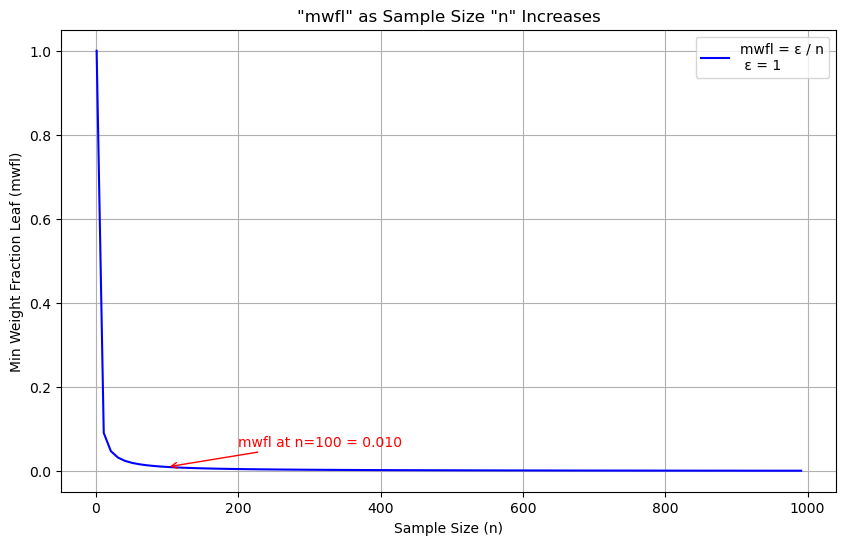

In [ ]:
w = 1
n_values = np.arange(1, 1001, 10)  # Range of sample sizes, from 1 to 1000, step of 10

# Compute mwfl for each value of n
mwfl_values = w / n_values

# Value of mwfl at n=10
n_annotation = 100
mwfl_annotation = w / n_annotation

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(n_values, mwfl_values, label='mwfl = ε / n\n ε = 1', color='b')

# Add annotation at n=10
plt.annotate(
    f'mwfl at n={n_annotation} = {mwfl_annotation:.3f}',
    xy=(n_annotation, mwfl_annotation),
    xytext=(n_annotation + 100, mwfl_annotation + 0.05),  # Offset for clarity
    arrowprops=dict(arrowstyle='->', color='red'),
    fontsize=10,
    color='red'
)

# Labels and Title
plt.xlabel('Sample Size (n)')
plt.ylabel('Min Weight Fraction Leaf (mwfl)')
plt.title('\"mwfl\" as Sample Size \"n\" Increases')
plt.legend()
plt.grid(True)
plt.show()